# Table of Contents
- [HTSEQ-COUNT](#HTSEQ-COUNT)
- [Prepare for DE analysis using htseq-count results](#Prepare-for-DE-analysis-using-htseq-count-results)
- [ERCC expression analysis: raw counts vs TPM](#ERCC-expression-analysis:-rawcounts-vs-TPM)
- [edgeR DE Analysis](#edgeR-DE-Analysis)
- [Compare the EdgeR's sigDE genes to those saved earlier from ballgown](#Compare-the-EdgeR's-sigDE-genes-to-those-saved-earlier-from-ballgown)
- [DESeq2 DE Analysis](#DESeq2-DE-Analysis)
    - [Setup and Format htseq counts data to work with DESeq2](#Setup-and-Format-htseq-counts-data-to-work-with-DESeq2)
        - [The course's method](#The-course's-method)
        - [read.table() method](#read.table()-method)
    - [Filter raw counts](#Filter-raw-counts)
    - [Specifying the experimental design](#Specifying-the-experimental-design)
    - [Construct the DESeq2 object piecing all the data together](#Construct-the-DESeq2-object-piecing-all-the-data-together)
    - [Running DESeq2](#Running-DESeq2)
    - [Log-fold change shrinkage](#Log-fold-change-shrinkage)
    - [Annotate gene symbols onto the DE results](#Annotate-gene-symbols-onto-the-DE-results)
    - [Top over-expressed genes](#Top-over-expressed-genes)
    - [Some output from R code above](#Some-output-from-R-code-above)
    - [Preliminary exploration of DE genes using webtools](#Preliminary-exploration-of-DE-genes-using-webtools)

# HTSEQ-COUNT
**Run htseq-count on alignments to produce raw counts (instead of FPKM/TPM values by Stringtie) for differential expression analysis with edgeR or DESeq2 downstream.**

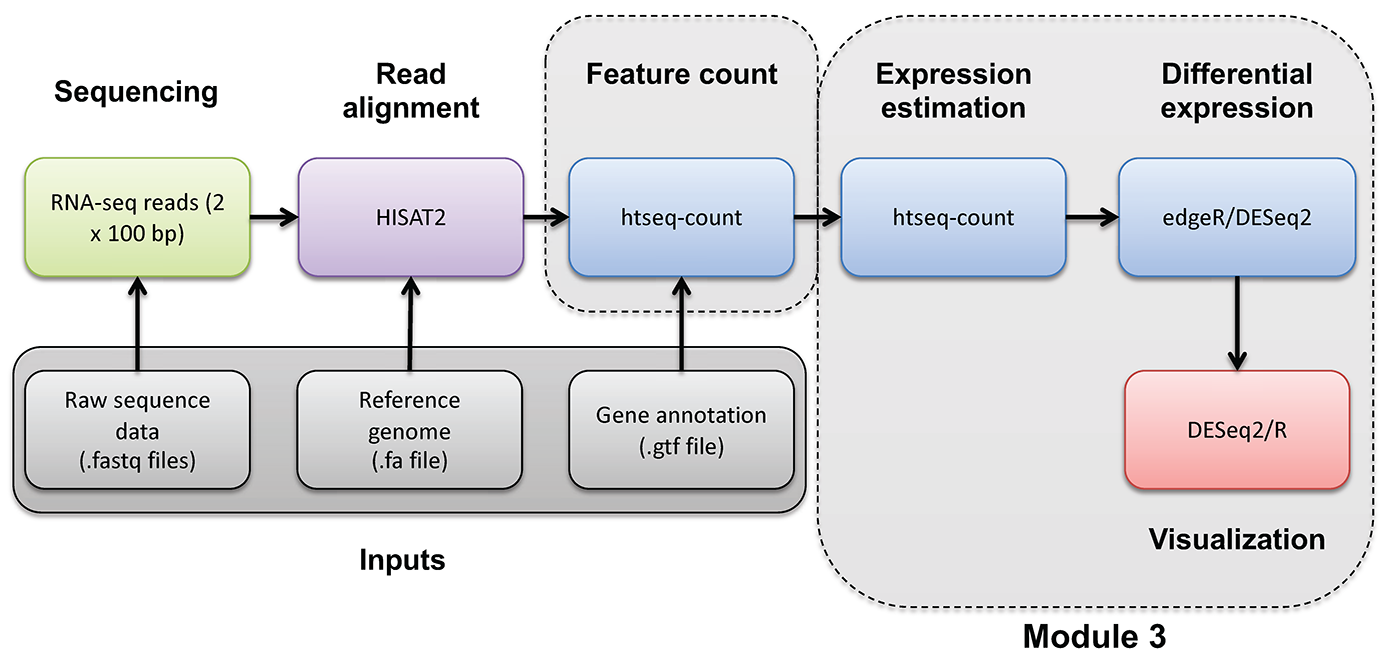

## Usage:
**htseq-count [options] <alignment_files> <gff/gtf_file>**

Or:

**python -m HTSeq.scripts.count [options] <alignment_files> <gff/gtf_file>** \
\
**Refer to the [HTSeq latest documentation for a more detailed explanation](https://htseq.readthedocs.io/en/latest/htseqcount.html).** 
- Given a file with aligned sequencing reads and a list of genomic features, a common task is to count how many reads map to each feature. htseq-count is designed for **gene as feature**. 
- The htseq-count script allows to choose between three modes (union, intersection-strict, intersection-nonempty). Of course, if none of these fits your needs, you can write your own script with HTSeq. See the chapter [A tour through HTSeq](https://htseq.readthedocs.io/en/latest/tour.html#tour) for a step-by-step guide on how to do so. 

**Some of the useful FAQs in this document are:**
1. Which overlap mode should I use?
- When the author wrote htseq-count, he was not sure which option is best and included three possibilities. Now, several years later, he have seen very few cases where the default union would not be appropriate and hence tend to recommend to just stick to union.

2. For paired-end data, does htseq-count count reads or read pairs?
- Read pairs. The script is designed to count “units of evidence” for gene expression. If both mates map to the same gene, this still only shows that one cDNA fragment originated from that gene. Hence, it should be counted only once.

2. What happens if the two reads in a pair overlap two different features?
- The same as if one read overlaps two features: The read or read pair is counted as ambiguous.

3. What happend if the mate of an aligned read is not aligned?
- For the default mode “union”, only the aligned read determines how the read pair is counted. For the other modes, see their description.

4. Most of my RNA-Seq reads are counted as ``__no_feature``. What could have gone wrong?
- Common causes include: - The --stranded option was set wrongly. Use a genome browser (e.g., IGV) to check. - The GTF file uses coordinates from another reference assembly as the SAM file. - The chromosome names differ between GTF and SAM file (e.g., chr1 in GTF and just 1 in SAM).

In [ ]:
cd $RNA_HOME/
mkdir -p expression/htseq_counts
cd expression/htseq_counts

htseq-count --format bam --order pos --mode intersection-strict --stranded reverse --minaqual 1 --type exon --idattr gene_id $RNA_ALIGN_DIR/UHR_Rep1.bam $RNA_REF_GTF > UHR_Rep1_gene.tsv
htseq-count --format bam --order pos --mode intersection-strict --stranded reverse --minaqual 1 --type exon --idattr gene_id $RNA_ALIGN_DIR/UHR_Rep2.bam $RNA_REF_GTF > UHR_Rep2_gene.tsv
htseq-count --format bam --order pos --mode intersection-strict --stranded reverse --minaqual 1 --type exon --idattr gene_id $RNA_ALIGN_DIR/UHR_Rep3.bam $RNA_REF_GTF > UHR_Rep3_gene.tsv

htseq-count --format bam --order pos --mode intersection-strict --stranded reverse --minaqual 1 --type exon --idattr gene_id $RNA_ALIGN_DIR/HBR_Rep1.bam $RNA_REF_GTF > HBR_Rep1_gene.tsv
htseq-count --format bam --order pos --mode intersection-strict --stranded reverse --minaqual 1 --type exon --idattr gene_id $RNA_ALIGN_DIR/HBR_Rep2.bam $RNA_REF_GTF > HBR_Rep2_gene.tsv
htseq-count --format bam --order pos --mode intersection-strict --stranded reverse --minaqual 1 --type exon --idattr gene_id $RNA_ALIGN_DIR/HBR_Rep3.bam $RNA_REF_GTF > HBR_Rep3_gene.tsv

#### You can easily condense these repetitive htseq-count commands using a simple Bash for loop. (Thanks, ChatGPT)
**Why this is better:**
- Easier to read
- Less chance of typos
- Easier to update parameters in one place

**Note: I follow the syntax in [the lastest htseq-count version document](https://htseq.readthedocs.io/en/latest/htseqcount.html)** \
-a instead of --minaqual

In [1]:
htseq-count --version

1.99.2


In [2]:
cd $RNA_HOME/ #RNA_HOME=/home/ubuntu/workspace/rnaseq
mkdir -p expression/htseq_counts
cd expression/htseq_counts

for sample in UHR_Rep1 UHR_Rep2 UHR_Rep3 HBR_Rep1 HBR_Rep2 HBR_Rep3
do
  htseq-count --format bam --order pos --mode intersection-strict \
    --stranded reverse -a 1 --type exon --idattr gene_id \
    "$RNA_ALIGN_DIR/${sample}.bam" "$RNA_REF_GTF" > "${sample}_gene.tsv"
done

56295 GFF lines processed.
100000 alignment record pairs processed.
200000 alignment record pairs processed.
227392 alignment record pairs processed.
56295 GFF lines processed.
100000 alignment record pairs processed.
162373 alignment record pairs processed.
56295 GFF lines processed.
100000 alignment record pairs processed.
185442 alignment record pairs processed.
56295 GFF lines processed.
100000 alignment record pairs processed.
118571 alignment record pairs processed.
56295 GFF lines processed.
100000 alignment record pairs processed.
144826 alignment record pairs processed.
56295 GFF lines processed.
100000 alignment record pairs processed.
129786 alignment record pairs processed.


**-f <> , --format=<>** \
    Format of the input data. Possible values are sam (for text SAM files) and bam (for binary BAM files). Default is sam.

**-r <>, --order=<>** \
    For paired-end data, the alignment have to be sorted either by read name or by alignment position. If your data is not sorted, use the samtools 	sort function of samtools to sort it. Use this option, with name or pos for <order> to indicate how the input data has been sorted. The default is 	name. \
	If name is indicated, htseq-count expects all the alignments for the reads of a given read pair to appear in adjacent records in the input data. 	For pos, this is not expected; rather, read alignments whose mate alignment have not yet been seen are kept in a buffer in memory until the mate 	is found. While, strictly speaking, the latter (order by pos) will also work with unsorted data, sorting ensures that most alignment mates appear 	close to each other in the data and hence the buffer is much less likely to overflow.

**-m <>, --mode=<>** \
    Mode to handle reads overlapping more than one feature. Possible values for <mode> are union, intersection-strict and intersection-nonempty 		(default: union)

**-s <yes/no/reverse>, --stranded=<yes/no/reverse>** \
    whether the data is from a strand-specific assay (default: yes) \
	For stranded=no, a read is considered overlapping with a feature regardless of whether it is mapped to the same or the opposite strand as the 		feature. For stranded=yes and single-end reads, the read has to be mapped to the same strand as the feature. For paired-end reads, the first read 	has to be on the same strand and the second read on the opposite strand. For stranded=reverse, these rules are reversed.

**-a <>, --a=<>** \
    skip all reads with alignment quality lower than the given minimum value (default: 10 — Note: the default used to be 0 until version 0.5.4.)

**-t <>, --type=<>** \
    Feature type (3rd column in GTF file) to be used, all features of other type are ignored (default, suitable for RNA-Seq analysis using an Ensembl 	GTF file: exon)

**-i <>, --idattr=<>** \
	GTF attribute to be used as feature ID. Several GTF lines with the same feature ID will be considered as parts of the same feature. The feature ID 	is used to identity the counts in the output table. The default, suitable for RNA-Seq analysis using an Ensembl GTF file, is **gene_id**

#### Merge results files into a single matrix for use in edgeR. The following joins the results for each replicate together, adds a header, reformats the result as a tab delimited file, and shows you the first 10 lines of the resulting file :

In [8]:
cd $RNA_HOME/expression/htseq_counts/
join UHR_Rep1_gene.tsv UHR_Rep2_gene.tsv | join - UHR_Rep3_gene.tsv | join - HBR_Rep1_gene.tsv | join - HBR_Rep2_gene.tsv | join - HBR_Rep3_gene.tsv > gene_read_counts_table_all.tsv
echo "GeneID UHR_Rep1 UHR_Rep2 UHR_Rep3 HBR_Rep1 HBR_Rep2 HBR_Rep3" > header.txt
cat header.txt gene_read_counts_table_all.tsv | grep -v "__" | awk -v OFS="\t" '$1=$1' > gene_read_counts_table_all_final.tsv
rm -f gene_read_counts_table_all.tsv header.txt
head gene_read_counts_table_all_final.tsv | column -t

GeneID           UHR_Rep1  UHR_Rep2  UHR_Rep3  HBR_Rep1  HBR_Rep2  HBR_Rep3
ENSG00000008735  13        17        8         397       531       466
ENSG00000015475  103       64        100       40        42        48
ENSG00000025708  46        16        26        13        11        19
ENSG00000025770  188       116       154       73        78        71
ENSG00000040608  18        8         11        69        91        81
ENSG00000054611  70        47        66        36        43        40
ENSG00000056487  12        13        7         11        10        4
ENSG00000063515  0         0         0         0         0         0
ENSG00000069998  123       76        137       25        40        33


**grep -v "double underscores"** removes all lines where the gene name starts with double underscores, e.g.:
- __no_feature
- __ambiguous
- __too_low_aQual

If you download UHR_Rep1_gene.tsv (by click on the file at http://your-public-IPv4/rnaseq/expression/htseq_counts/) and view it with Sublime Text/NotePad/etc., you'll see these __things at the bottom:

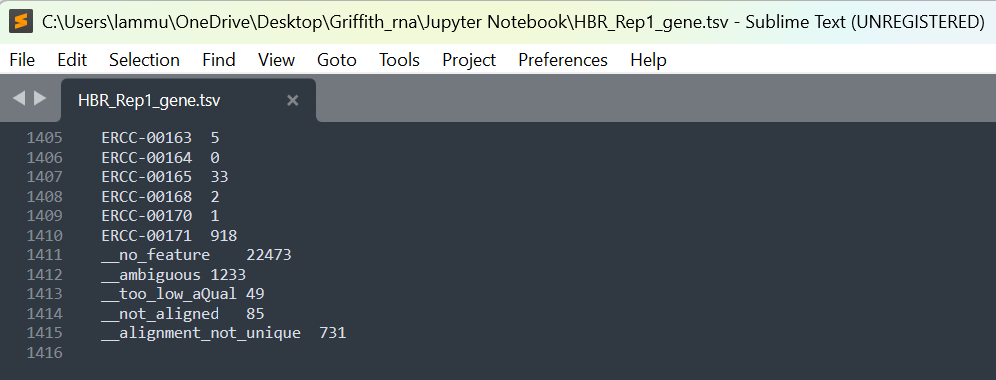
 
**awk -v OFS="\t" ...** this is a clever trick to reformat the spacing into proper tab-separated format:

**rm -f** force remove file(s)

# Prepare for DE analysis using htseq-count results
Create a directory for the DEseq analysis based on the htseq-count results:

In [10]:
cd $RNA_HOME/
mkdir -p de/htseq_counts
cd de/htseq_counts

Note that the htseq-count results provide counts for each gene but uses only the Ensembl Gene ID (e.g. ENSG00000054611). This is not very convenient for biological interpretation. This next step creates a mapping file that will help us translate from ENSG IDs to Symbols. 

It does this by parsing the GTF transcriptome file we got from Ensembl. That file contains both gene names and IDs. Unfortunately, this file is a bit complex to parse. Furthermore, it contains the ERCC transcripts, and these have their own naming convention which also complicates the parsing.

Before manipulating our GTF transciptome file, let's view its content, just the 1st line: \
(To refresh your memory on GTF file manipulation, view Module01_annotations_indexing.ipynb)

In [16]:
echo -e "chrom\tsource\tfeature\tstart\tend\tscore\tstrand\tframe\tattribute"
head -n 1 $RNA_REF_GTF

chrom	source	feature	start	end	score	strand	frame	attribute
22	ensembl	gene	10736171	10736283	.	-	.	gene_id "ENSG00000277248"; gene_version "1"; gene_name "U2"; gene_source "ensembl"; gene_biotype "snRNA";


In [ ]:
# Method 1 to extract gene name

perl -ne 'if ($_ =~ /gene_id\s\"(ENSG\S+)\"\;/) { $id = $1; $name = undef; if ($_ =~ /gene_name\s\"(\S+)"\;/) { $name = $1; }; }; if ($id && $name) {print "$id\t$name\n";} if ($_=~/gene_id\s\"(ERCC\S+)\"/){print "$1\t$1\n";}' $RNA_REF_GTF | sort | uniq > ENSG_ID2Name.txt
head ENSG_ID2Name.txt

In [17]:
# Method 2 to extract gene name

# cut the 9th column with all the gene annotation information
# delete all the double quotes from this string
# use perl to search for the pattern "gene_id" or "gene_name" followed by space character and then some non-space characters. 
# the non-space characters are the actual gene ID or Name. Store these in variables $gid and $gname and then print them out
# use sort and unique commands to produce a unique list of gene_name, gene_id combinations

cut -f 9 $RNA_REF_GTF | tr -d '"' | perl -ne 'chomp; if ($_ =~ /gene_id\s+(\S+);/){$gid = $1}; if ($_ =~ /gene_name\s+(\S+);/){$gname = $1}; print "$gid\t$gname\n"' | sort | uniq > ENSG_ID2Name.txt

head ENSG_ID2Name.txt

ENSG00000008735	MAPK8IP2
ENSG00000015475	BID
ENSG00000025708	TYMP
ENSG00000025770	NCAPH2
ENSG00000040608	RTN4R
ENSG00000054611	TBC1D22A
ENSG00000056487	PHF21B
ENSG00000063515	GSC2
ENSG00000069998	CECR5
ENSG00000070010	UFD1L


What it does:
1. cut -f 9 extracts the 9th field (the attribute field) from the GTF file.
2. tr -d '"' removes any double quotes that might be in the attribute values, making parsing easier.
3. The perl script:
    - Extracts the gene_id and gene_name from the attribute field.
    - If a gene_id is found, it stores it in the variable gid.
    - If a gene_name is found, it stores it in the variable gname.
    - It then prints the gene_id and gene_name together in a tab-separated format, even if gene_id and gene_name are on different lines.
    - The sort | uniq at the end removes duplicate gene-id/gene-name pairs.

*Key Insight:* 
This code outputs the gene_id and gene_name for each gene, even if they appear on different lines in the GTF. If a gene_name appears after a gene_id in another line, it will associate the last seen gene_id with that gene_name.

In [19]:
# My version of code don't work well because it didn't account for when gene_ID and gene_name pair is not on the same line
cut -f9 $RNA_REF_GTF | cut -d ' ' -f2,6 | tr -d '";' | sort -u | head 

ENSG00000008735 ENST00000008876
ENSG00000008735 ENST00000329492
ENSG00000008735 MAPK8IP2
ENSG00000015475 BID
ENSG00000015475 ENST00000317361
ENSG00000015475 ENST00000342111
ENSG00000015475 ENST00000399765
ENSG00000015475 ENST00000399767
ENSG00000015475 ENST00000399774
ENSG00000015475 ENST00000473439


### Determine the number of unique Ensembl Gene IDs and symbols. What does this tell you?

In [20]:
#count unique gene ids
cut -f 1 ENSG_ID2Name.txt | sort | uniq | wc -l

#count unique gene names
cut -f 2 ENSG_ID2Name.txt | sort | uniq | wc -l

#show the most repeated gene names
cut -f 2 ENSG_ID2Name.txt | sort | uniq -c | sort -r | head

1410
1378
     13 Y_RNA
     12 Metazoa_SRP
      3 SCARNA17
      2 U6
      2 RNU12
      2 RFPL3-AS1_1
      2 LINC01422
      2 ELFN2
      2 DUXAP8
      2 DGCR5


#### ✅ multiple gene_ids can map to 1 gene_name due to:
1. Different gene versions or loci:
    - Some gene names refer to gene families or paralogs located at different positions in the genome.
    - Ensembl assigns a unique gene_id to each genomic locus, even if multiple loci represent the same gene name.

2. Pseudogenes or readthrough genes:
    - Some gene names are reused for pseudogenes or readthrough transcripts, which get their own gene_id.

3. Annotation conventions:
    - Ensembl may reuse gene names for related transcripts/genes, e.g., TP53 might also show up for pseudogenes like TP53P1.

4. Gene name collisions:
    - Gene names (gene_name) are often not globally unique identifiers, unlike gene_id which are.
    - It's not unusual for multiple different gene_ids to be assigned the same human-readable gene_name.

#### 📊 Our numbers:

| Metric            | Count |
|-------------------|-------|
| Unique gene_ids	| 1410  |
| Unique gene_names	| 1378  |

**So 32 gene_ids share gene_names with others.**

# ERCC expression analysis: raw counts vs TPM
Based on the above read counts, plot the linearity of the ERCC spike-in read counts observed in our RNA-seq data versus the expected concentration of the ERCC spike-in Mix.

First download a file describing the expected concentrations and fold-change differences for the ERCC spike-in reagent.

In [21]:
mkdir $RNA_HOME/expression/ercc_spikein_analysis/
cd $RNA_HOME/expression/ercc_spikein_analysis/
wget http://genomedata.org/rnaseq-tutorial/ERCC_Controls_Analysis.txt
cat ERCC_Controls_Analysis.txt

--2025-05-11 12:45:55--  http://genomedata.org/rnaseq-tutorial/ERCC_Controls_Analysis.txt
Resolving genomedata.org (genomedata.org)... 54.71.55.4
Connecting to genomedata.org (genomedata.org)|54.71.55.4|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://genomedata.org/rnaseq-tutorial/ERCC_Controls_Analysis.txt [following]
--2025-05-11 12:45:55--  https://genomedata.org/rnaseq-tutorial/ERCC_Controls_Analysis.txt
Connecting to genomedata.org (genomedata.org)|54.71.55.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4086 (4.0K) [text/plain]
Saving to: ‘ERCC_Controls_Analysis.txt’

ERCC_Controls_Analy 100%[===================>]   3.99K  --.-KB/s    in 0s      

2025-05-11 12:45:55 (3.02 GB/s) - ‘ERCC_Controls_Analysis.txt’ saved [4086/4086]

Re-sort ID	ERCC ID	subgroup	concentration in Mix 1 (attomoles/ul)	concentration in Mix 2 (attomoles/ul)	expected fold-change ratio	log2(Mix 1/Mix 2)
1	ERCC-00130	A	30000	7500	4	2

## Produce x-y scatter plots that compare the expected and observed values for HTSEQ raw counts and StringTie TPM abundance estimates.

**I break up code chunks for us to understand each step easier.** \
**Because this Jupyter Notebook's kernel is Bash, R scripts don't run smoothly here. And it's uneccesary to install R Jupyter kernel just to run this R code seperately. I'll run these commands on my WSL terminal and took screenshot of output/paste the output here.**

In [ ]:
R
library("ggplot2")
library("data.table")

After loading library, you will get a message (optional) followed by ">"

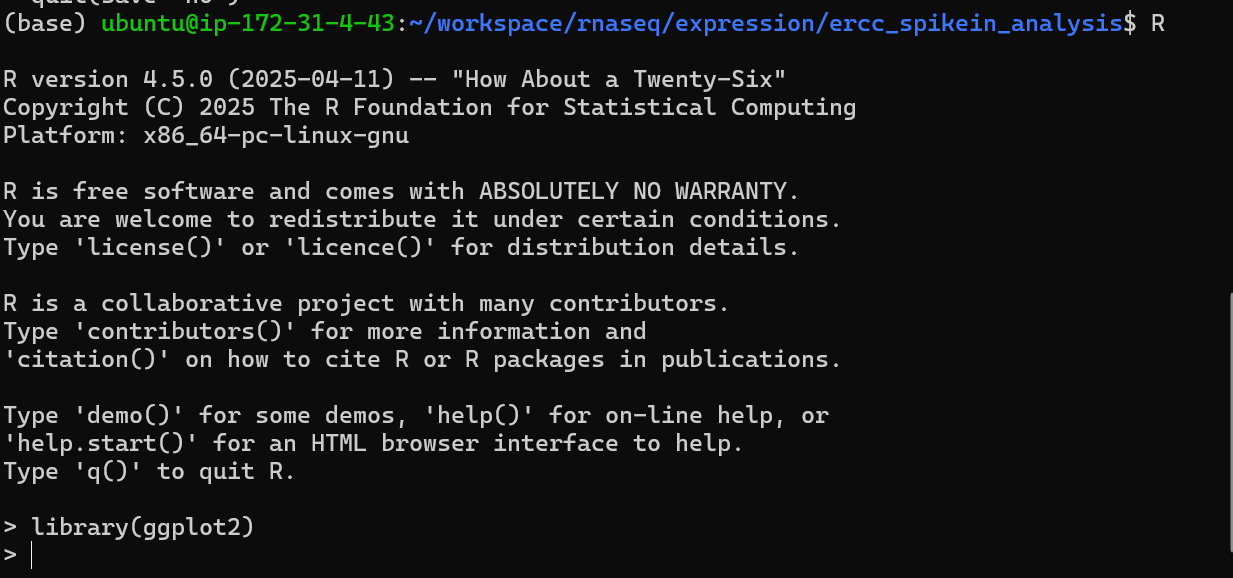

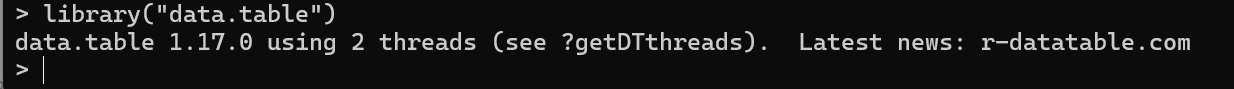


In [ ]:
#load in the reference/expected concentration and fold change values for each ERCC transcript
ercc_ref = read.table("ERCC_Controls_Analysis.txt", header=TRUE, sep="\t")
names(ercc_ref) = c("id", "ercc_id", "subgroup", "ref_conc_mix_1", "ref_conc_mix_2", "ref_fc_mix1_vs_mix2", "ref_log2_mix1_vs_mix2")
head(ercc_ref)
dim(ercc_ref)

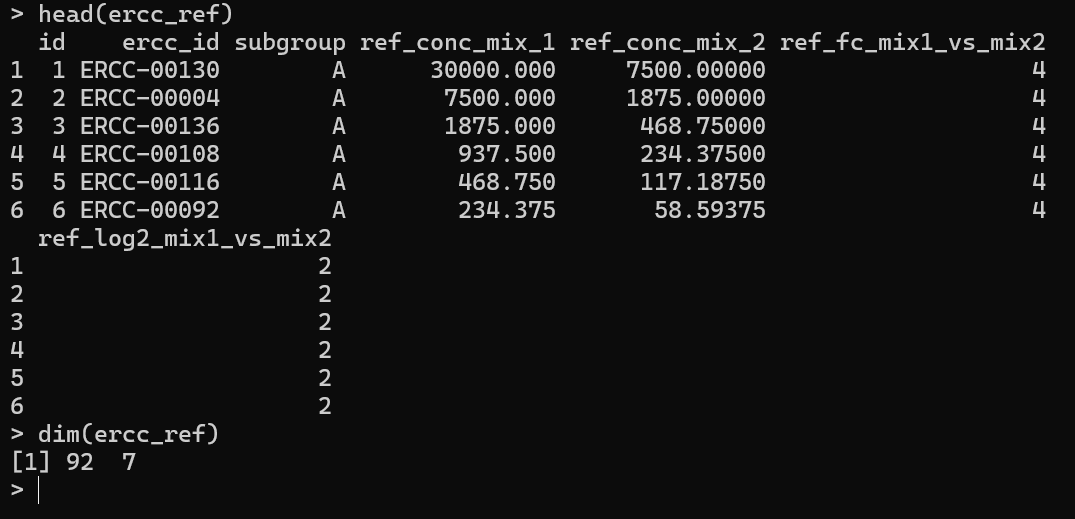

### x-y scatter plot for HTSEQ raw counts

In [ ]:
#load the RNA-seq raw counts values for all samples and combined with the expected ERCC values
rna_counts_file = "~/workspace/rnaseq/expression/htseq_counts/gene_read_counts_table_all_final.tsv";
rna_counts = read.table(rna_counts_file, header=TRUE, sep="\t")
dim(rna_counts)

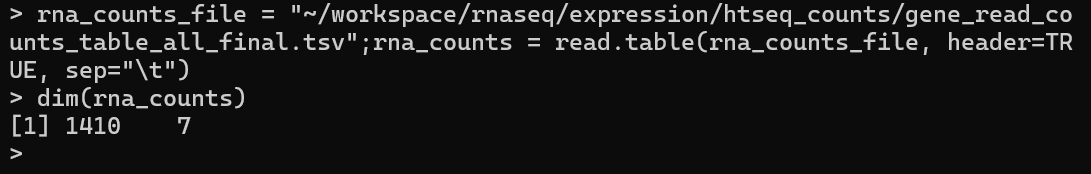

In [ ]:
#combine the ERCC expected concentration information with the observed htseq counts
ercc_ref_counts = merge(x = ercc_ref, y = rna_counts, by.x = "ercc_id", by.y = "GeneID", all.x = TRUE)

#convert UHR data to "long" format
uhr_data = ercc_ref_counts[,c("ercc_id","subgroup","ref_conc_mix_1","UHR_Rep1","UHR_Rep2","UHR_Rep3")]
uhr_data_long = melt(setDT(uhr_data), id.vars = c("ercc_id","subgroup","ref_conc_mix_1"), variable.name = "sample")
uhr_data_long$mix = 1
names(uhr_data_long) = c("ercc_id", "subgroup", "concentration", "sample", "count", "mix")

#convert HBR data to "long" format
hbr_data = ercc_ref_counts[,c("ercc_id","subgroup","ref_conc_mix_2","HBR_Rep1","HBR_Rep2","HBR_Rep3")]
hbr_data_long = melt(setDT(hbr_data), id.vars = c("ercc_id","subgroup","ref_conc_mix_2"), variable.name = "sample")
hbr_data_long$mix = 2
names(hbr_data_long) = c("ercc_id", "subgroup", "concentration", "sample", "count", "mix")

#rejoin the UHR and HBR tpm data
ercc_ref_counts_long <- rbind(uhr_data_long, hbr_data_long)
head(ercc_ref_counts_long)
dim(ercc_ref_counts_long)

**Note: You can paste a chuck of code (multiple lines) for R to run at once:**

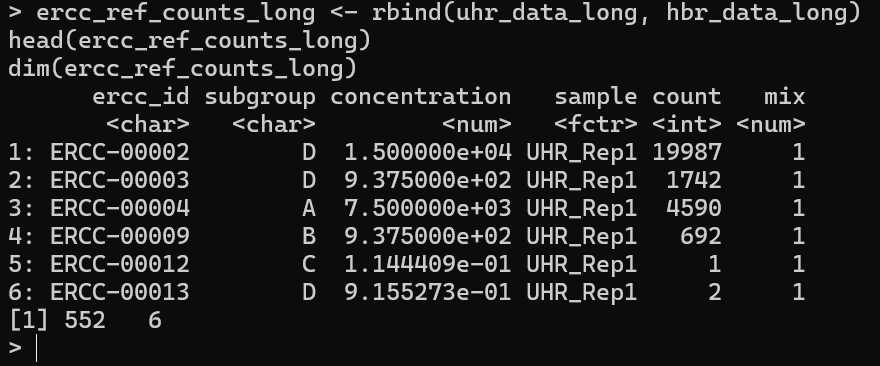

In [ ]:
#fit a linear model and calculate correlation between expected concentations and observed htseq counts
ercc_ref_counts_long$log_count = log2(ercc_ref_counts_long$count + 1)
ercc_ref_counts_long$log_concentration= log2(ercc_ref_counts_long$concentration)

count_model <- lm(log_count ~ log_concentration, data=ercc_ref_counts_long)
count_r_squared = summary(count_model)[["r.squared"]]
count_slope = coef(count_model)["log_concentration"]

p1 = ggplot(ercc_ref_counts_long, aes(x=log_concentration, y=log_count))
p1 = p1 + geom_point(aes(shape=sample, color=sample))
p1 = p1 + geom_smooth(method=lm) 
p1 = p1 + annotate("text", 5, -3, label=paste("R^2 =", count_r_squared, sep=" ")) 
p1 = p1 + annotate("text", 5, -4, label=paste("Slope =", count_slope, sep=" "))
p1 = p1 + xlab("Expected concentration (log2 scale)") + ylab("Observed Count (log2 scale)")

pdf("ERCC_Count_Expression_vs_SpikeInConcentration.pdf")
print(p1)
dev.off()

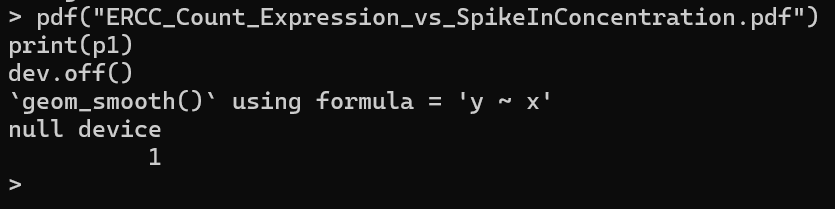

**Now you can view the pdf at: http://your-public-Ipv4/rnaseq/expression/ercc_spikein_analysis/ERCC_Count_Expression_vs_SpikeInConcentration.pdf**

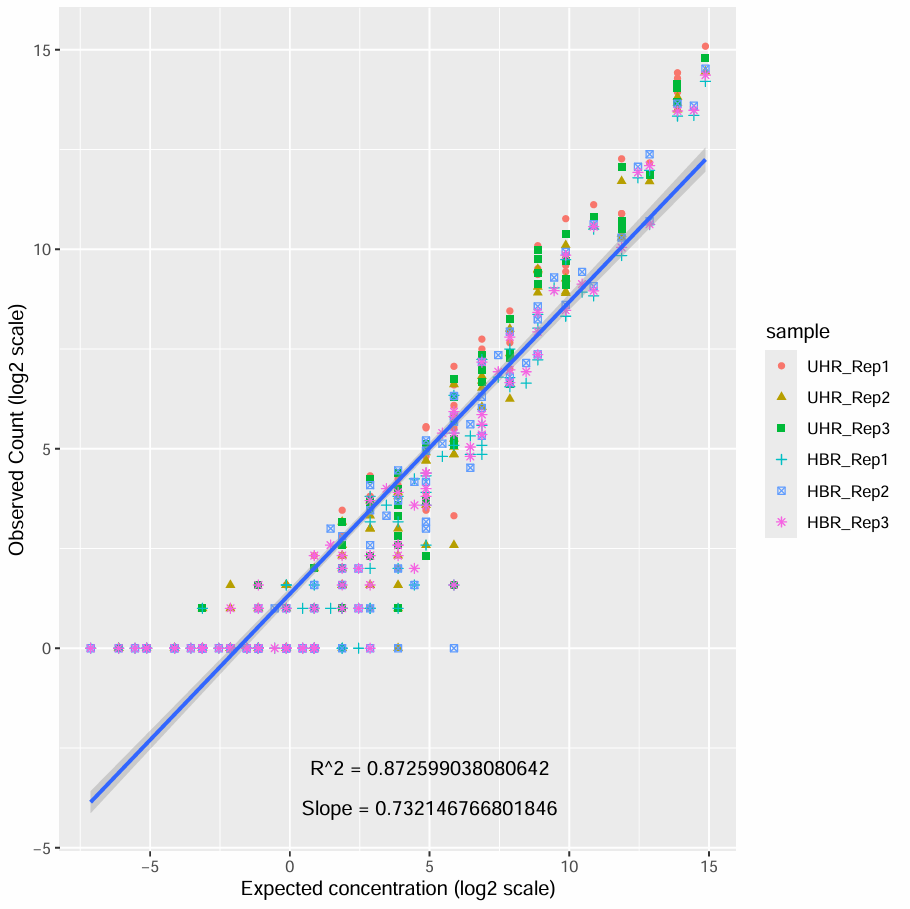

### x-y scatter plot for StringTie TPM abundance estimates

In [ ]:
#load the RNA-seq TPM values for all samples and combine with expected ERCC values
rna_tpms_file = "~/workspace/rnaseq/expression/stringtie/ref_only/gene_tpm_all_samples.tsv"
rna_tpms = read.table(rna_tpms_file, header=TRUE, sep="\t")
dim(rna_tpms) #output: [1] 1410    7

#combine the ERCC expected concentration information with the observed RNA-seq TPM values
ercc_ref_tpms = merge(x = ercc_ref, y = rna_tpms, by.x = "ercc_id", by.y = "Gene_ID", all.x = TRUE)
dim(ercc_ref_tpms) #output: [1] 92 13

#convert UHR data to "long" format
uhr_data = ercc_ref_tpms[,c("ercc_id","subgroup","ref_conc_mix_1","UHR_Rep1","UHR_Rep2","UHR_Rep3")]
uhr_data_long = melt(setDT(uhr_data), id.vars = c("ercc_id","subgroup","ref_conc_mix_1"), variable.name = "sample")
uhr_data_long$mix = 1
names(uhr_data_long) = c("ercc_id", "subgroup", "concentration", "sample", "tpm", "mix")

#convert HBR data to "long" format
hbr_data = ercc_ref_tpms[,c("ercc_id","subgroup","ref_conc_mix_2","HBR_Rep1","HBR_Rep2","HBR_Rep3")]
hbr_data_long = melt(setDT(hbr_data), id.vars = c("ercc_id","subgroup","ref_conc_mix_2"), variable.name = "sample")
hbr_data_long$mix = 2
names(hbr_data_long) = c("ercc_id", "subgroup", "concentration", "sample", "tpm", "mix")

#rejoin the UHR and HBR tpm data
ercc_ref_tpms_long <- rbind(uhr_data_long, hbr_data_long)
head(ercc_ref_tpms_long)
dim(ercc_ref_tpms_long) #output: [1] 552   6

#fit a linear model and calculate correlation between expected concentations and observed TPM values
ercc_ref_tpms_long$log_tpm = log2(ercc_ref_tpms_long$tpm + 1)
ercc_ref_tpms_long$log_concentration= log2(ercc_ref_tpms_long$concentration)

tpm_model <- lm(log_tpm ~ log_concentration, data=ercc_ref_tpms_long)
tpm_r_squared = summary(tpm_model)[["r.squared"]]
tpm_slope = coef(tpm_model)["log_concentration"]

p2 = ggplot(ercc_ref_tpms_long, aes(x=log_concentration, y=log_tpm))
p2 = p2 + geom_point(aes(shape=sample, color=sample))
p2 = p2 + geom_smooth(method=lm) 
p2 = p2 + annotate("text", 5, -3, label=paste("R^2 =", tpm_r_squared, sep=" ")) 
p2 = p2 + annotate("text", 5, -4, label=paste("Slope =", tpm_slope, sep=" "))
p2 = p2 + xlab("Expected concentration (log2 scale)") + ylab("Observed TPM estimate (log2 scale)")

pdf("ERCC_TPM_Expression_vs_SpikeInConcentration.pdf")
print(p2)
dev.off()

# Exit the R session
quit(save="no")


You can view TPM scatter plot pdf at: http://your-public-IPv4/rnaseq/expression/ercc_spikein_analysis/ERCC_TPM_Expression_vs_SpikeInConcentration.pdf

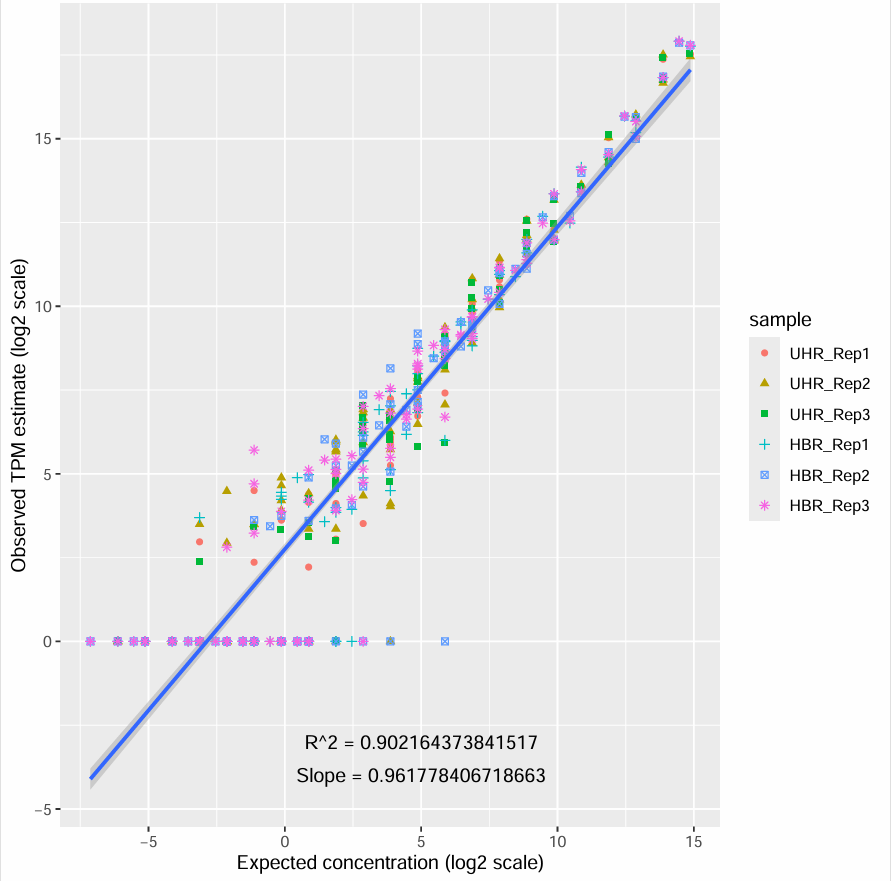

#### View the 2 plots, Which expression estimation (read counts or TPM values) are better representing the known/expected ERCC concentrations? Why?
ERCC_TPM expression estimation can be considered a better representation of the known or expected ERCC spike-in concentrations if it has an R^2 value closer to 1 compared to ERCC_count.

# edgeR DE Analysis
#### In this tutorial you will: 
1. Make use of the raw counts you generated previously using htseq-count
2. edgeR is a bioconductor package designed specifically for differential expression of count-based RNA-seq data
3. This is an alternative to using stringtie/ballgown to find differentially expressed genes
##### First, create a directory for results (already did in "Prepare for DE analysis using htseq-count results" step above):

In [1]:
cd $RNA_HOME/
mkdir -p de/htseq_counts
cd de/htseq_counts

#### Launch R and run the following commands:

In [ ]:
R

# set working directory where output will go
working_dir = "~/workspace/rnaseq/de/htseq_counts"
setwd(working_dir)

# read in gene mapping
mapping = read.table("~/workspace/rnaseq/de/htseq_counts/ENSG_ID2Name.txt", header = FALSE, stringsAsFactors = FALSE, row.names = 1) #Uses the first column (Ensembl Gene IDs) as row names
# To view ENSG_ID2Name.txt as R object called mapping: head(mapping)
# To view ENSG_ID2Name.txt in WSL: head ENSG_ID2Name.txt

# read in count matrix
rawdata = read.table("~/workspace/rnaseq/expression/htseq_counts/gene_read_counts_table_all_final.tsv", header = TRUE, stringsAsFactors = FALSE, row.names = 1)
# To view gene_read_counts_table_all_final.tsv as R object called rawdata: head(rawdata)
# to view gene_read_counts_table_all_final.tsv in WSL: cd $RNA_HOME/expression/htseq_counts/; head gene_read_counts_table_all_final.tsv | column -t


# Check dimensions
dim(rawdata) #output: [1] 1410    6 (ir, 1410 Ensembl Gene IDs and 6 samples: UHR_Rep1  UHR_Rep2  UHR_Rep3  HBR_Rep1  HBR_Rep2  HBR_Rep3)

# Require at least 1/6 of samples to have expressed count >= 10
sample_cutoff = (1/6) # Agene must be "expressed" in at least 1 out of 6 samples (~16.7%) to be kept.
count_cutoff = 10 #A gene is considered "expressed" in a sample if its read count is ≥10.

#Define a function to calculate the fraction of values expressed above the count cutoff
getFE = function(data,count_cutoff){
 FE = (sum(data >= count_cutoff) / length(data))
 return(FE)
}

###
# getFE function calculates the fraction of samples in which a gene is expressed above the count_cutoff.
# For a given gene (row in rawdata), it:
## Counts how many samples satisfy count_cutoff, which is count ≥10
## Divides by total number of samples, legnth(data), which is 6
# Returns that fraction.

# For example, if 2 out of 6 samples have count ≥10, it returns 2/6 = 0.333.
###

#Apply the function to all genes, and filter out genes not meeting the sample cutoff
fraction_expressed = apply(rawdata, 1, getFE, count_cutoff)
keep = which(fraction_expressed >= sample_cutoff)
rawdata = rawdata[keep, ] #keeping only the rows (genes) that pass the cutoff.

####

# apply(rawdata, 1, getFE, count_cutoff) applies getFE() to each row (gene) of rawdata:
## 1 – this tells apply() to operate across rows (i.e., for each gene).
### 1 = apply the function to rows
### 2 = apply the function to columns

####

# Check dimensions again to see effect of filtering
dim(rawdata) #output: [1] 449   6; from 1410 Ensembl Gene IDs to 449 gene IDs 

#################
# Running edgeR #
#################

# load edgeR
library("edgeR")

# make class labels
class = c(rep("UHR", 3), rep("HBR", 3))

# Get gene IDs that passed the filtering
Gene = rownames(rawdata) #rawdata contains 449 Ensembl Gene IDs that passed the cutoff
# Pulls the corresponding gene symbols from the mapping table using Ensembl IDs as keys.
Symbol = mapping[Gene, 1] #"mapping" is ENSG_ID2Name.txt with Ensembl Gene IDs as row names; this step extract gene symbols for gene IDs that passed the filtering
# Combines the two into a 2-column matrix:
gene_annotations = cbind(Gene, Symbol)

# Make DGEList object
y = DGEList(counts = rawdata, genes = gene_annotations, group = class)
nrow(y) #output: [1] 449

# TMM (Trimmed Mean of M component) Normalization
y = calcNormFactors(y)

# Estimate dispersion
y = estimateCommonDisp(y, verbose = TRUE)
y = estimateTagwiseDisp(y) #output: Disp = 0.00224 , BCV = 0.0473

# Differential expression test: compares two groups (e.g. UHR vs HBR) and gives log fold changes and p-values for each gene.
et = exactTest(y) 

# Extract raw counts to add back onto DE results
counts = getCounts(y) #  even after TMM normalization, getCounts(y) still extracts the original raw counts from the DGEList object y.

# to have a sneak peak of statistic significant genes before Benjamini-Hochberg FDR correction
topTags(et) #output is sorted by increasing raw p-value

# Print number of up/down significant genes at FDR = 0.05  significance level
summary(de <- decideTests(et, adjust.method = "BH", p = 0.05)) #p in this case is adjusted p-value (FDR). 
# as.logical(de) is TRUE only for genes with adjusted p-value (FDR) ≤ 0.05

#Get output with BH-adjusted FDR values - all genes, any p-value, unsorted
out = topTags(et, n = "Inf", adjust.method = "BH", sort.by = "none", p.value = 1)$table #includes all genes, regardless of significance (FDR ≤ 1 means everyone is included)
# if don't indicate p.value = 1, the default p.value is 0.05)

#Add raw counts back onto results for convenience (make sure sort and total number of elements allows proper join)
out2 = cbind(out, counts) # full result (out2) to just the DE genes (out3), and then sort those by significance (out4).

#Limit to significantly DE genes
out3 = out2[as.logical(de), ] #as.logical(de) selects genes where de ≠ 0 (either up or down) and Keep only significantly DE genes (FDR ≤ 0.05)

# Order by p-value
o = order(et$table$PValue[as.logical(de)], decreasing=FALSE)
out4 = out3[o, ] #Orders the significant DE genes in out3 by increasing p-value (most significant genes first).

# Save table
write.table(out4, file = "edgeR_DE_genes.txt", quote = FALSE, row.names = FALSE, sep = "\t")

#To exit R type the following
quit(save = "no")

### Some output from the above R commands and detail explanation for certain functions:
#### 1. ENSG_ID2Name.txt as R object called mapping

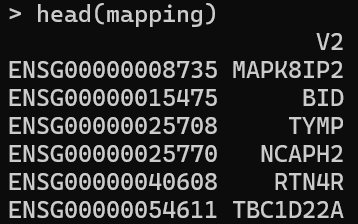

#### 2. gene_annotations is now a matrix of size 449 × 2, containing the gene IDs and their readable gene symbols only for genes that passed the filter 

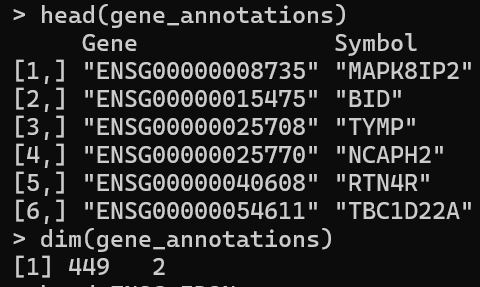

#### 3. [DGEList object](https://rdrr.io/bioc/edgeR/man/DGEList.html)
Creates a DGEList object from a table of counts (rows=features, columns=samples), group indicator for each column, library size (optional) and a table of feature annotation (optional).

##### Usage
DGEList(counts = matrix(0, 0, 0), lib.size = colSums(counts),
        norm.factors = rep(1,ncol(counts)), samples = NULL,
        group = NULL, genes = NULL, remove.zeros = FALSE)

##### Arguments:
- **counts: numeric matrix of read counts.**
- lib.size: numeric vector giving the total count (sequence depth) for each library.
- norm.factors: numeric vector of normalization factors that modify the library sizes.
- samples: data frame containing information for each sample.
- **group: vector or factor giving the experimental group/condition for each sample/library.**
- **genes: data frame containing annotation information for each gene.**
- remove.zeros: logical, whether to remove rows that have 0 total count.

#### 4. TMM (explained by ChatGPT)

**🚀 Why TMM matters for our analysis**
- Without normalization: A sample with more total reads (or lots of highly expressed genes) would dominate the analysis.
- With TMM: We can fairly compare gene expression between conditions, making your exactTest(y) results valid and reliable.TMM is a method used in RNA-seq data analysis to normalize gene expression counts across samples, so you can fairly compare them.

**🧠 How it works (in plain terms):**

    1) Pick a reference sample:
        - The sample whose 75th percentile log-count is closest to the mean of all samples
    2) For each other sample, calculate M-values (log-fold changes) and A-values (average expression) for each gene.
    3) Trim away:
        - Genes with extreme M-values (too different)
        - Genes with very low or very high expression
    4) Take the mean of the remaining M-values.
    5) Use this mean to calculate a scaling factor that adjusts the sample’s counts.

**📌 What calcNormFactors(y) uses as the reference sample?**
TMM (via calcNormFactors in edgeR) automatically picks a reference sample, not based on group labels like UHR or HBR, but based on the sample whose 75th percentile log-count is closest to the mean of all samples. The reference sample will have a norm factor of 1, and others are scaled relative to it.

**🔍 y$samples**

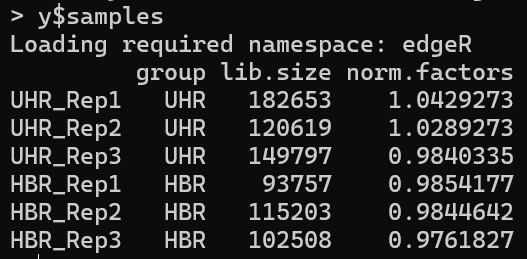

📘 What this tells you:

✅ Library size differences
Your samples have different total read counts. E.g., UHR_Rep1 has nearly double the reads of HBR_Rep1.

Raw counts alone aren’t comparable across samples due to this.

✅ Normalization is correcting for composition bias
The norm.factors adjust for more than just library size — they also correct for RNA composition bias (e.g., a few genes dominating the total reads).

For example:
- UHR_Rep1 has a norm factor > 1, meaning it had higher expression values overall, and needs to be scaled down.
- HBR_Rep3 has a norm factor < 1, meaning it had lower counts overall, and needs to be scaled up.

✅ Your data is ready for fair comparisons
After applying calcNormFactors, all downstream steps (like dispersion estimation and differential expression) will use these factors to ensure that comparisons between samples are statistically valid.

**📌 What does topTags(et) mean by: "Comparison of groups: UHR - HBR"?**

That part does use your group = class input. 

It means that edgeR is computing log-fold changes as UHR minus HBR. So:
- A positive logFC → gene is more highly expressed in UHR
- A negative logFC → gene is more highly expressed in HBR

| Step                 | What determines reference?                                 |
| -------------------- | ---------------------------------------------------------- |
| `calcNormFactors(y)` | Based on library size distribution (not your group labels) |
| `topTags(et)`        | Based on `group = class`; **UHR - HBR** direction          |

#### 5. Dispersion and Biological Coefficient of Variations (BCV)
✅ estimateTagwiseDisp(y)
- Now edgeR estimates a separate dispersion for each gene ("tagwise dispersion").
- This is more accurate and powerful than using a single value.
- It uses the common dispersion as a prior to shrink the tagwise values (empirical Bayes).
- Disp = 0.00224: This is the average tagwise dispersion across all 449 genes.
  
✅ estimateCommonDisp(y, verbose = TRUE)
- Estimates a single dispersion value (common dispersion) shared across all genes.
- This is useful when you have few replicates and cannot estimate gene-specific variability well.
- verbose = TRUE prints details of the fitting procedure.
- The dispersion captures biological variability beyond what you'd expect from just Poisson (random) variation.
- BCV = 0.0473: This is the Biological Coefficient of Variation, which is calculated as the square root of the dispersion (Disp):

\begin{equation*}
\text{BCV} = \sqrt{\text{Disp}} = \sqrt{0.00224} \approx 0.0473
\end{equation*}


| Term                     | Meaning                                                                                                                                                               |
| ------------------------ | --------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Dispersion (0.00224)** | Low variability between replicates for most genes. This is good — it means your replicates are consistent.                                                            |
| **BCV (4.73%)**          | On average, the **biological variation** between samples within a group is \~4.73%. This is **very low**, indicating high-quality data with minimal biological noise. |


#### 6. View counts

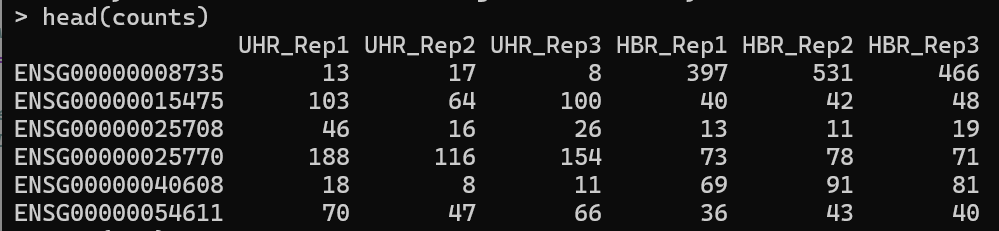

#### 7. topTags(et): View top genes (sorted by p-value) before Benjamini-Hochberg FDR correction

🔍 topTags(et): 
- Input: The result from exactTest(y) (which is stored in et)
- Output: A data frame of genes sorted by increasing raw p-value (but will show only first 10 genes by defaut), including:
    - logFC: log₂ fold change between groups
    - logCPM: average log₂ expression
    - **PValue: raw p-value**
    - FDR: BH-adjusted p-value (False Discovery Rate)

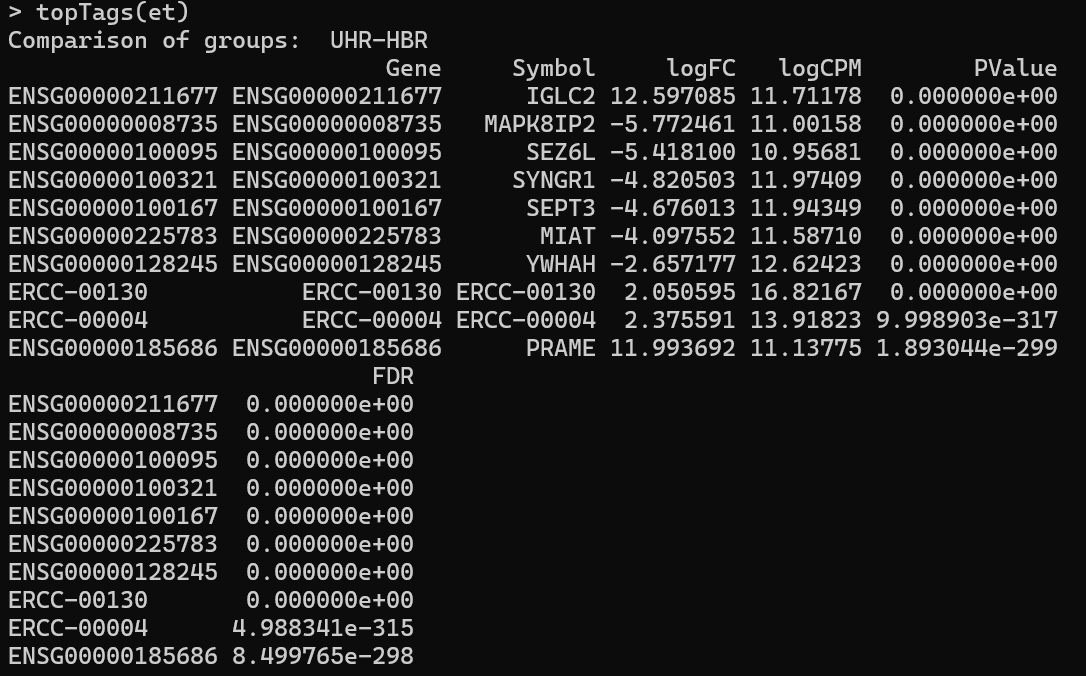

#### 8. de is created below. It’s a matrix (or vector) indicating:

- 1 for up-regulated genes,
- -1 for down-regulated genes,
- 0 for non-significant genes.
- adjust.method = "BH" applies the Benjamini-Hochberg correction for multiple testing.
- summary() prints the number of up/down/non-significant genes.

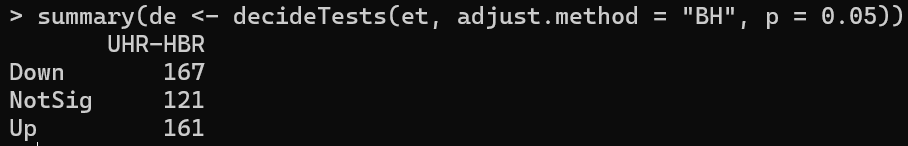

#### 9. Difference between et and out
et is the result of the differential expression test: et = exactTest(y)

This contains:
- logFC (log2 fold-change),
- logCPM (log2 counts per million),
- PValue (unadjusted p-value for differential expression).

out is created from et using topTags(): out = topTags(et, n = "Inf", adjust.method = "BH", sort.by = "none", p.value = 1)$table

This returns a data frame that includes:
- Everything in et$table
- plus: an extra column with adjusted p-values (usually FDRs), calculated using the Benjamini-Hochberg (BH) method.

📘 What does logCPM mean? logCPM = log₂(counts per million) \
- It gives you a normalized expression level for each gene:
- Normalizes for sequencing depth (library size).
- Expressed on a log scale for easier comparison across genes and samples.
- logCPM is not group-specific — it's an average expression across all samples, primarily for visualization and filtering.

🧪 Is FDR the False Discovery Rate?
- Yes! ✅ FDR = False Discovery Rate
- It controls for multiple testing:
- When you test thousands of genes, some will have small p-values just by chance.
- FDR correction (like Benjamini-Hochberg) reduces the number of false positives.
- If you use an FDR cutoff of 0.05, you expect about 5% of the "significant" genes to be false discoveries.

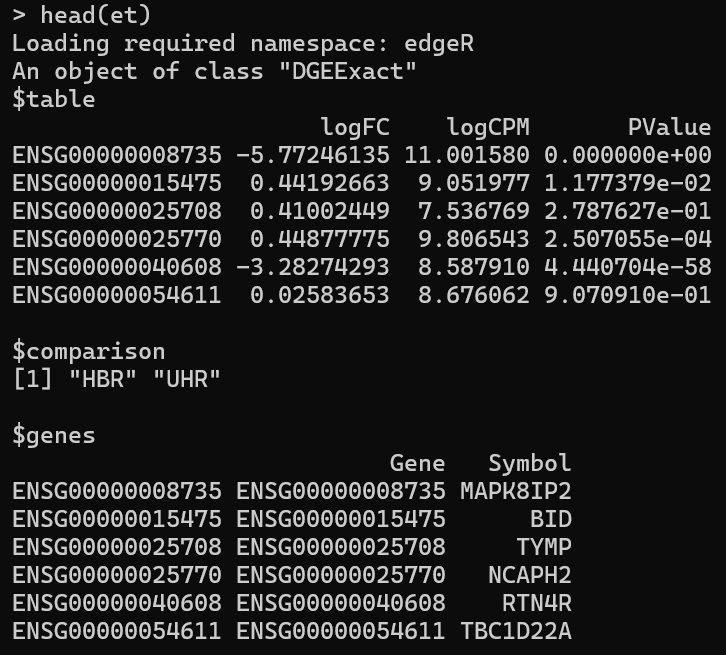

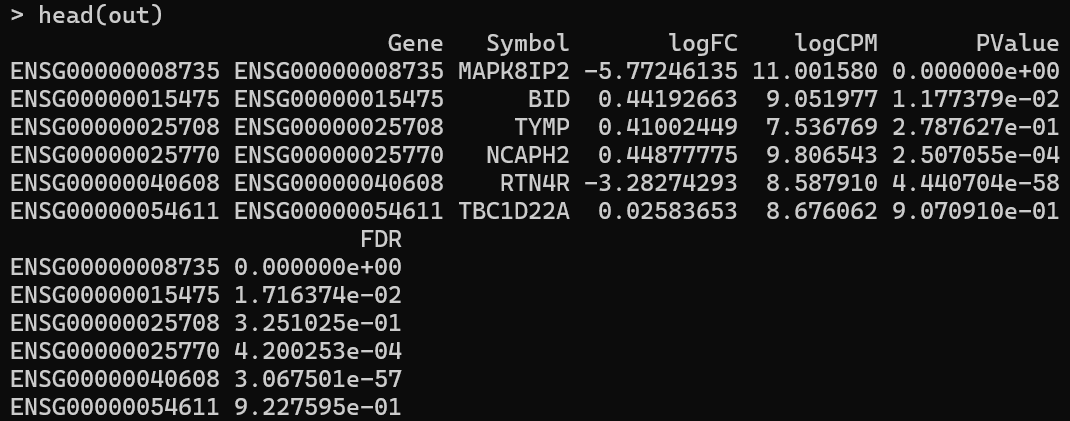

#### 10. To take a short break from R -> save all assigned variables
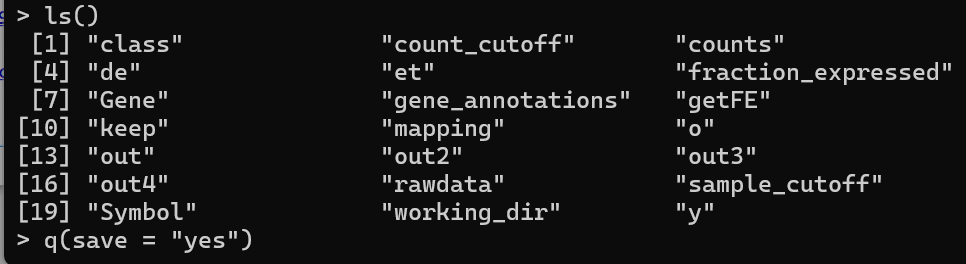

# Compare the EdgeR's sigDE genes to those saved earlier from ballgown

In [1]:
head $RNA_HOME/de/ballgown/ref_only/DE_genes.txt

MAPK8IP2
BID
NCAPH2
RTN4R
CECR5
UFD1L
CLTCL1
DGCR2
PANX2
GTSE1


In [2]:
head $RNA_HOME/de/htseq_counts/edgeR_DE_genes.txt

Gene	Symbol	logFC	logCPM	PValue	FDR	UHR_Rep1	UHR_Rep2	UHR_Rep3	HBR_Rep1	HBR_Rep2	HBR_Rep3
ENSG00000008735	MAPK8IP2	-5.77246134796536	11.0015798667181	0	0	13	17	8	397	531	466
ENSG00000100095	SEZ6L	-5.41809969461722	10.9568127145503	0	0	15	13	19	393	499	452
ENSG00000100167	SEPT3	-4.67601313753789	11.9434865752832	0	0	55	39	55	738	917	876
ENSG00000100321	SYNGR1	-4.82050329629467	11.9740908286879	0	0	51	46	41	756	987	853
ENSG00000128245	YWHAH	-2.65717712176941	12.6242267540693	0	0	332	217	290	1024	1351	1139
ENSG00000211677	IGLC2	12.597085220189	11.7117797841618	0	0	1205	709	894	0	0	0
ENSG00000225783	MIAT	-4.0975522703455	11.587099758385	0	0	64	46	62	600	683	670
ERCC-00130	ERCC-00130	2.05059455102012	16.8216682149818	0	0	34882	22442	28573	4042	5337	4382
ERCC-00004	ERCC-00004	2.37559103673602	13.9182347242706	9.99890251679773e-317	4.9883413672625e-315	4590	3332	3690	455	538	497


## Pull out the gene symbols from ballgown and EdgeR

In [3]:
cd $RNA_HOME/de/

cut -f 1 $RNA_HOME/de/ballgown/ref_only/DE_genes.txt | sort | uniq > ballgown_DE_gene_symbols.txt
cut -f 2 $RNA_HOME/de/htseq_counts/edgeR_DE_genes.txt | sort | uniq | grep -v Gene_Name > htseq_counts_edgeR_DE_gene_symbols.txt

### View these files on web browser:
- http://YOUR_PUBLIC_IPv4_ADDRESS/rnaseq/de/ballgown_DE_gene_symbols.txt
- http://YOUR_PUBLIC_IPv4_ADDRESS/rnaseq/de/htseq_counts_edgeR_DE_gene_symbols.txt

### Let's examine how many unique gene symbols ballgown (p<0.05) and EdgeR (adjusted p-value (FDR) ≤ 0.05) produce seperately:

In [4]:
wc -l ballgown_DE_gene_symbols.txt
wc -l htseq_counts_edgeR_DE_gene_symbols.txt

311 ballgown_DE_gene_symbols.txt
328 htseq_counts_edgeR_DE_gene_symbols.txt


### Visualize overlap with a venn diagram. This can be done with simple web tools like:

- https://www.biovenn.nl/ (this will also give us list of non-overlapping and overlapping genes by each method)
- http://bioinfogp.cnb.csic.es/tools/venny/

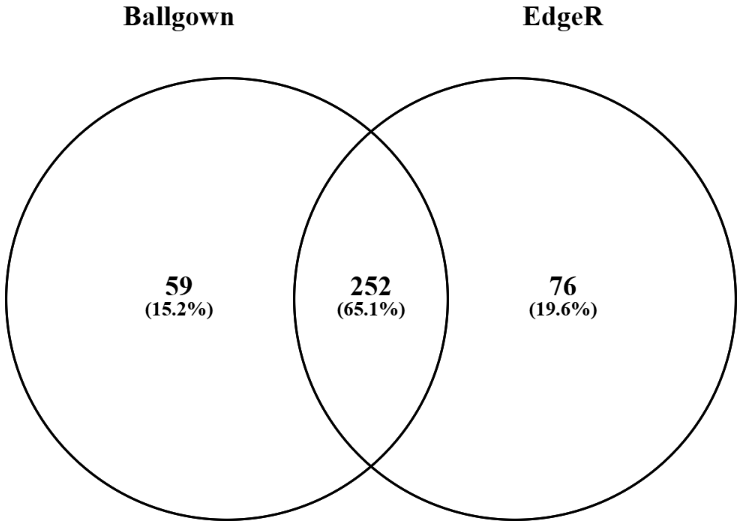

# DESeq2 DE Analysis
- Similar to EdgeR
- Make use of the raw counts you generated previously using htseq-count
- DESeq2 is a bioconductor package designed specifically for differential expression of count-based RNA-seq data
- This is an alternative to using stringtie/ballgown to find differentially expressed genes

Two pieces of information are required to perform analysis with DESeq2. A matrix of raw counts, such as was generated previously while running HTseq previously in this course. This is important as DESeq2 normalizes the data, correcting for differences in library size using using this type of data. DESeq2 also requires the experimental design which can be supplied as a data.frame, detailing the samples and conditions.

In [1]:
cd $RNA_HOME/de/
mkdir deseq2
cd deseq2

## Setup and Format htseq counts data to work with DESeq2
### The course's method

This is a multi-step process that:
1. Loads a file via fread() (from data.table)
2. Converts it to a matrix
3. Sets row names from the GeneID column
4. Removes the GeneID column from the data
5. Converts the matrix data type from character to integer

In [ ]:
R

library(DESeq2)
library(data.table)
library(ggplot2)

# set working directory where output will go
datadir = "~/workspace/rnaseq/de/deseq2"
setwd(datadir)

# read in count matrix
htseqCounts = fread("~/workspace/rnaseq/expression/htseq_counts/gene_read_counts_table_all_final.tsv")

# view the class of the data
class(htseqCounts) #data.table

# convert the data.table to matrix format
htseqCounts = as.matrix(htseqCounts)
class(htseqCounts) 

# set the gene ID values to be the row names for the matrix
rownames(htseqCounts) = htseqCounts[, "GeneID"]

# now that the gene IDs are the row names, remove the redundant column that contains them
htseqCounts = htseqCounts[, colnames(htseqCounts) != "GeneID"]

# convert the count values from strings (with spaces) to integers, because originally the gene column contained characters, the entire matrix was set to character
class(htseqCounts) = "integer"

# view the first few lines of the gene count matrix
head(htseqCounts)

### read.table() method
We've been using read.table for EdgeR so I asked ChatGPT if we can use it for DESeq2. ChatGPT confirmed that:

**read.table() call does everything we need:**
1. Reads the file
2. Sets the gene IDs as row names
3. Keeps everything else as a numeric data frame

In [ ]:
R

library(DESeq2)
library(data.table)
library(ggplot2)

# set working directory where output will go
datadir = "~/workspace/rnaseq/de/deseq2"
setwd(datadir)

htseqCounts <- read.table(
  "~/workspace/rnaseq/expression/htseq_counts/gene_read_counts_table_all_final.tsv",
  header = TRUE,
  row.names = 1,
  stringsAsFactors = FALSE,
  #check.names = FALSE #use if your column names are sample IDs that contain spaces, dashes, or other special characters
)

# Ensure numeric matrix format for DESeq2
htseqCounts <- as.matrix(htseqCounts)
mode(htseqCounts) <- "numeric"

head(htseqCounts)
class(htseqCounts) #output: "matrix" "array"
str(htseqCounts)

## Filter raw counts
Before running DESeq2 (or any differential expression analysis) it is useful to pre-filter data. There are computational benefits to doing this as the memory size of the objects within R will decrease and DESeq2 will have less data to work through and will be faster. By removing “low quality” data, it is also reduces the number of statistical tests that will be performed, which in turn reduces the impact of multiple test correction and can lead to more significant genes.

The amount of pre-filtering is up to the analyst however, it should be done in an unbiased way. DESeq2 recommends removing any gene with less than 10 reads across all samples. Below, we filter a gene if at least 1 sample does not have at least 10 reads (same as when using EdgeR). Either way, mostly what is being removed here are genes with very little evidence for expression in any sample (in many cases gene with 0 counts in all samples).

In [ ]:
# run a filtering step
# i.e. require that for every gene: at least 1 of 6 samples must have counts greater than 10
# get index of rows that meet this criterion and use that to subset the matrix
# note the dimensions of the matrix before and after filtering with dim()

# breaking apart the command below to understand it's outcome
tail(htseqCounts) # look at the raw counts
tail(htseqCounts >= 10) # determine which cells have counts greater than 10
tail(rowSums(htseqCounts >= 10)) # determine for which genes how many samples have counts greater than 10
tail(rowSums(htseqCounts >= 10) >= 1) # filter to those entries/genes for which at least one sample has counts greater than 10
tail(which(rowSums(htseqCounts >= 10) >= 1)) #obtain the index for the above filter criteria

dim(htseqCounts) #output: [1] 1410    6
htseqCounts = htseqCounts[which(rowSums(htseqCounts >= 10) >= 1), ]
dim(htseqCounts) #output: [1] 449   6

## Specifying the experimental design
As mentioned above DESeq2 also needs to know the experimental design, that is which samples belong to which condition to test. The experimental design for the example dataset herein is quite simple as there are 6 samples with two conditions to compare (UHR vs HBR), as such we can just create the experimental design right within R. There is one important thing to note, DESeq2 does not check sample names, it expects that the column names in the counts matrix we created correspond exactly to the row names we specify in the experimental design.

In [ ]:
# construct a mapping of the meta data for our experiment (comparing UHR cell lines to HBR brain tissues)
# this is defining the biological condition/label for each experimental replicate
# create a simple one column dataframe to start
metaData <- data.frame("Condition" = c("UHR", "UHR", "UHR", "HBR", "HBR", "HBR")) #the column names in htseqCounts: UHR_Rep1 UHR_Rep2 UHR_Rep3 HBR_Rep1 HBR_Rep2 HBR_Rep3

# convert the "Condition" column to a factor data type
# the arbitrary order of these factors will determine the direction of log2 fold-changes for the genes (i.e. up or down regulated)
metaData$Condition = factor(metaData$Condition, levels = c("HBR", "UHR"))

# set the row names of the metaData dataframe to be the names of our sample replicates from the read counts matrix
rownames(metaData) = colnames(htseqCounts) #the column names in htseqCounts: UHR_Rep1 UHR_Rep2 UHR_Rep3 HBR_Rep1 HBR_Rep2 HBR_Rep3

# view the metadata dataframe
head(metaData)

# check that names of htseq count columns match the names of the meta data rows
# use the "all" function which tests whether an entire logical vector is TRUE
all(rownames(metaData) == colnames(htseqCounts)) #output: [1] TRUE

## Construct the DESeq2 object piecing all the data together
With all the data properly formatted it is now possible to combine all the information required to run differental expression in one object. This object will hold the input data, and intermediary calculations. It is also where the condition to test is specified.

In [ ]:
# make deseq2 data sets
# here we are setting up our experiment by supplying: (1) the gene counts matrix, (2) the sample/replicate for each column, and (3) the biological conditions we wish to compare.
# this is a simple example that works for many experiments but these can also get more complex
# for example, including designs with multiple variables such as "~ group + condition",
# and designs with interactions such as "~ genotype + treatment + genotype:treatment".

dds = DESeqDataSetFromMatrix(countData = htseqCounts, colData = metaData, design = ~Condition)

# the design formula above is often a point of confussion, it is useful to put in words what is happening, when we specify "design = ~Condition" we are saying
# regress gene expression on condition, or put another way, model gene expression on condition
# gene expression is the response variable and condition is the explanatory variable
# you can put words to formulas using this [cheat sheet](https://www.econometrics.blog/post/the-r-formula-cheatsheet/)

## Running DESeq2
With all the data now in place, DESeq2 can be run. Calling DESeq2 will perform the following actions:
- Estimation of size factors. i.e. accounting for differences in sequencing depth (or library size) across samples.
- Estimation of dispersion. i.e. estimate the biological variability (over and above the expected variation from sampling) in gene expression across biological replicates. This is needed to assess the significance of differences across conditions. Additional work is performed to correct for higher dispersion seen for genes with low expression.
- Perform “independent filtering” to reduce the number of statistical tests performed (see ?results and this paper for details)
- Negative Binomial GLM fitting and performing the Wald statistical test
- Correct p values for multiple testing using the Benjamini-Hochberg method

In [ ]:
# run the DESeq2 analysis on the "dds" object
dds = DESeq(dds)

# view the first 5 lines of the DE results
res = results(dds)
head(res, 5)

## Log-fold change shrinkage
It is good practice to shrink the log-fold change values, this does exactly what it sounds like, reducing the amount of log-fold change for genes where there are few counts which create huge variability that is not truly biological signal. Consider for example a gene for two samples, one sample has 1 read, and and one sample has 6 reads, that is a 6 fold change, that is likely not accurate. There are a number of algorithms that can be used to shrink log2 fold change, here we will use the apeglm algorithm, which does require the apeglm package to be installed.

In [ ]:
# shrink the log2 fold change estimates
#   shrinkage of effect size (log fold change estimates) is useful for visualization and ranking of genes

#   In simplistic terms, the goal of calculating "dispersion estimates" and "shrinkage" is also to account for the problem that
#   genes with low mean counts across replicates tend of have higher variability than those with higher mean counts.
#   Shrinkage attempts to correct for this. For a more detailed discussion of shrinkage refer to the DESeq2 vignette

# first get the name of the coefficient (log fold change) to shrink
resultsNames(dds) #Output: [1] "Intercept"            "Condition_UHR_vs_HBR"

# now apply the shrinkage approach
BiocManager::install("apeglm")
library(apeglm)
resLFC = lfcShrink(dds, coef = "Condition_UHR_vs_HBR", type = "apeglm")

# make a copy of the shrinkage results to manipulate
deGeneResult = resLFC

# contrast the values before and after shrinkage
# create a temporary, simplified data structure with the values before/after shrinkage, and create a new column called "group" with this label
res_before = res
res_before$group = "before shrinkage"
res_after = deGeneResult
res_after$group = "after shrinkage"
res_combined = rbind(res_before[,c("log2FoldChange","group")], res_after[,c("log2FoldChange","group")])

# adjust the order so that the legend has "before shrinkage" listed first
res_combined$group = factor(res_combined$group, levels = c("before shrinkage", "after shrinkage"))

# look at the fold change values
head(res_before)
head(res_after)

p <- ggplot(res_combined, aes(x = log2FoldChange, color = group)) +
  geom_density() +
  theme_bw() +
  scale_color_manual(values = c("before shrinkage" = "tomato4", "after shrinkage" = "slategray")) +
  labs(color = "Shrinkage status")

pdf("DESeq2_log2FC__shrinkage.pdf")       # creates the PDF file
print(p)                                  # prints the plot into the PDF
dev.off()                                 # closes the file


## Annotate gene symbols onto the DE results
DESeq2 was run with ensembl gene IDs as identifiers, this is not the most human friendly way to interpret results. Here gene symbols are merged onto the differential expressed gene list to make the results a bit more interpretable.

We'll re-use the read.table() method we used in EdgeR section instead of fread().

In [ ]:
gene_id_mapping <- read.table(
  "~/workspace/rnaseq/de/htseq_counts/ENSG_ID2Name.txt",
  header = FALSE,
  stringsAsFactors = FALSE
)

colnames(gene_id_mapping) <- c("ensemblID", "Symbol")

#### 
# the fread() method the course used
# read in gene ID to name mappings (using "fread" an alternative to "read.table")
#gene_id_mapping <- fread("/cloud/project/data/bulk_rna/ENSG_ID2Name.txt", header = FALSE)

# add names to the columns in the "gene_id_mapping" dataframe
#setnames(gene_id_mapping, c("ensemblID", "Symbol"))
####


# view the first few lines of the gene ID to name mappings
head(gene_id_mapping)

# merge on gene names
# view head(deGeneResult) before adding a column called "ensemblID"
deGeneResult$ensemblID = rownames(deGeneResult) #you can view head(deGeneResult) again to see the change
# We must convert the DESeqResults object to a data.frame (or data.table) before merging.
deGeneResult <- as.data.frame(deGeneResult)
deGeneResult = merge(deGeneResult, gene_id_mapping, by = "ensemblID", all.x = TRUE)

# merge the original raw count values onto this final dataframe to aid interpretation
original_counts = as.data.frame(htseqCounts)
original_counts[,"ensemblID"] = rownames(htseqCounts)
deGeneResult = merge(deGeneResult, original_counts, by = 'ensemblID', all.x = TRUE)

# view the final merged dataframe
# based on the raw counts and fold change values what does a negative fold change mean with respect to our two conditions HBR and UHR?
head(deGeneResult)

## Top over-expressed genes
### Get genes with p-adj < 0.05
With the DE analysis complete it is useful to view and filter the data frames to only the relevant genes. Here some basic data manipulation is performed, filtering to significant genes at specific thresholds.

In [ ]:
# view the top genes according to adjusted p-value
head(deGeneResult[order(deGeneResult$padj), ])

# view the top genes according to fold change
head(deGeneResult[order(deGeneResult$log2FoldChange), ])

# determine the number of up/down significant genes at FDR < 0.05 significance level
dim(deGeneResult)[1] # number of genes tested: 449
dim(deGeneResult[deGeneResult$padj < 0.05, ])[1] #number of significant genes: 297

# order the DE results by adjusted p-value
deGeneResultSorted = deGeneResult[order(deGeneResult$padj), ]

# create a filtered data frame that limits to only the significant DE genes (adjusted p.value < 0.05)
deGeneResultSignificant = deGeneResultSorted[deGeneResultSorted$padj < 0.05, ]

# save the final DE result (all genes)  to an output file
fwrite(deGeneResultSorted, file="DE_all_genes_DESeq2.tsv", sep="\t")

# save the final DE result (significant genes only)  to an output file
fwrite(deGeneResultSignificant, file="DE_sig_genes_DESeq2.tsv", sep="\t")

# save the DESeq2 objects for the data visualization section
saveRDS(dds, "dds.rds")
saveRDS(res, "res.rds")
saveRDS(resLFC, "resLFC.rds")

### Get genes with p-adj < 0.05 and large log2FC
For both conditions (HBR and UHR) lets take a look at the top n genes but this time according to fold-change instead of p-value.

In [ ]:
# use the dplyr library to manipulate the dataframe
library(dplyr)

# create a new copy of the data frame, sorted by log2 fold change
deGeneResultSortedFoldchange = arrange(deGeneResultSignificant, log2FoldChange)

# create a convenient data structure with just the top n genes from each condition
top_bottom = bind_rows(
  head(deGeneResultSortedFoldchange, 10) %>% mutate(Set = "Bottom 10"),
  tail(deGeneResultSortedFoldchange, 10) %>% mutate(Set = "Top 10")
)

# visualize data for the top n genes. Simplify the output a bit
print(top_bottom[,c("log2FoldChange","padj","Symbol","UHR_Rep1","UHR_Rep2","UHR_Rep3","HBR_Rep1","HBR_Rep2","HBR_Rep3","Set")])

## Some output from R code above:

#### 1. Verifying that read.table() method works:

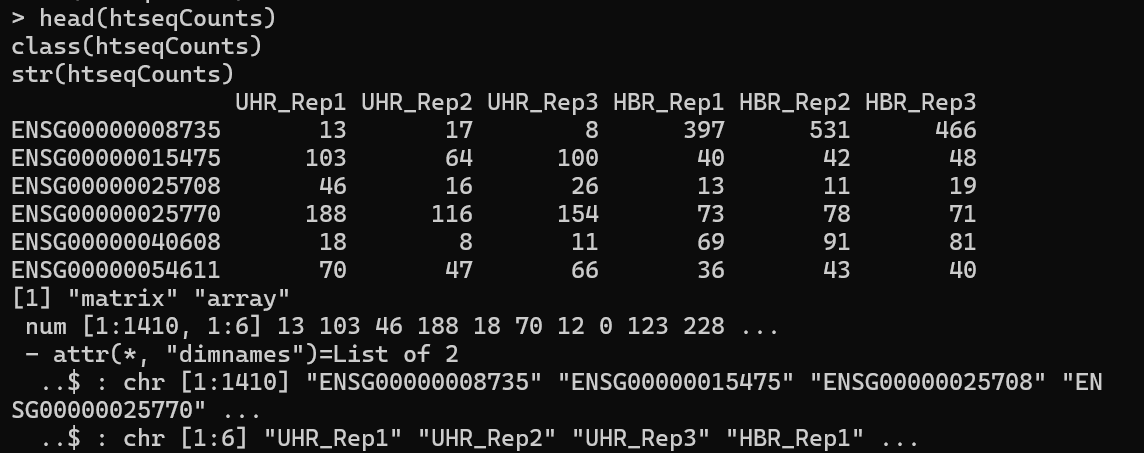

#### 2. See how to filter out genes with no sample having at least 10 counts

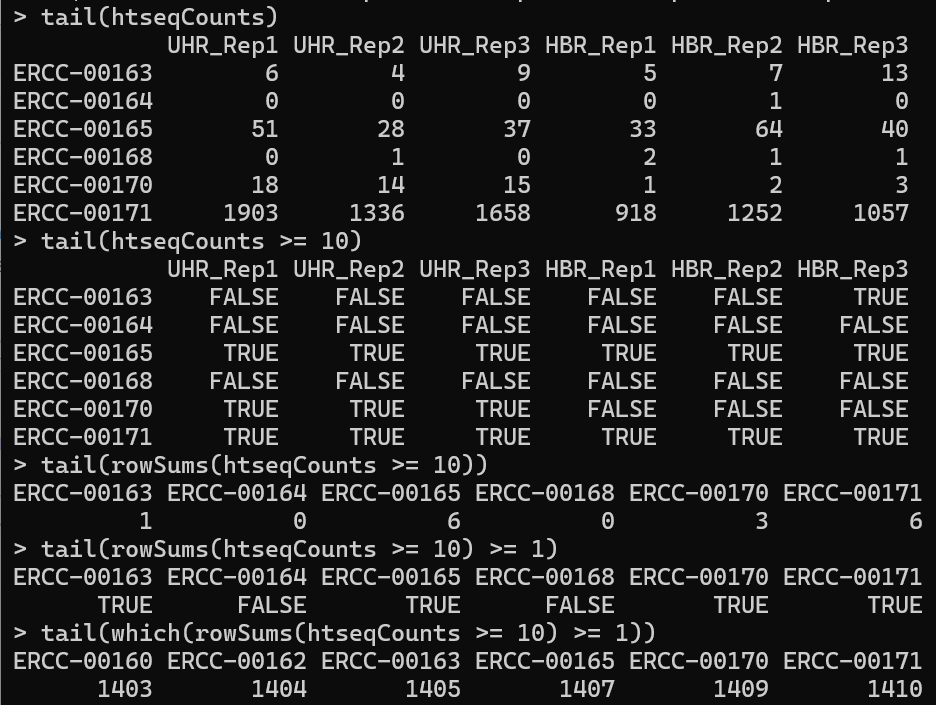

#### 3. metaData

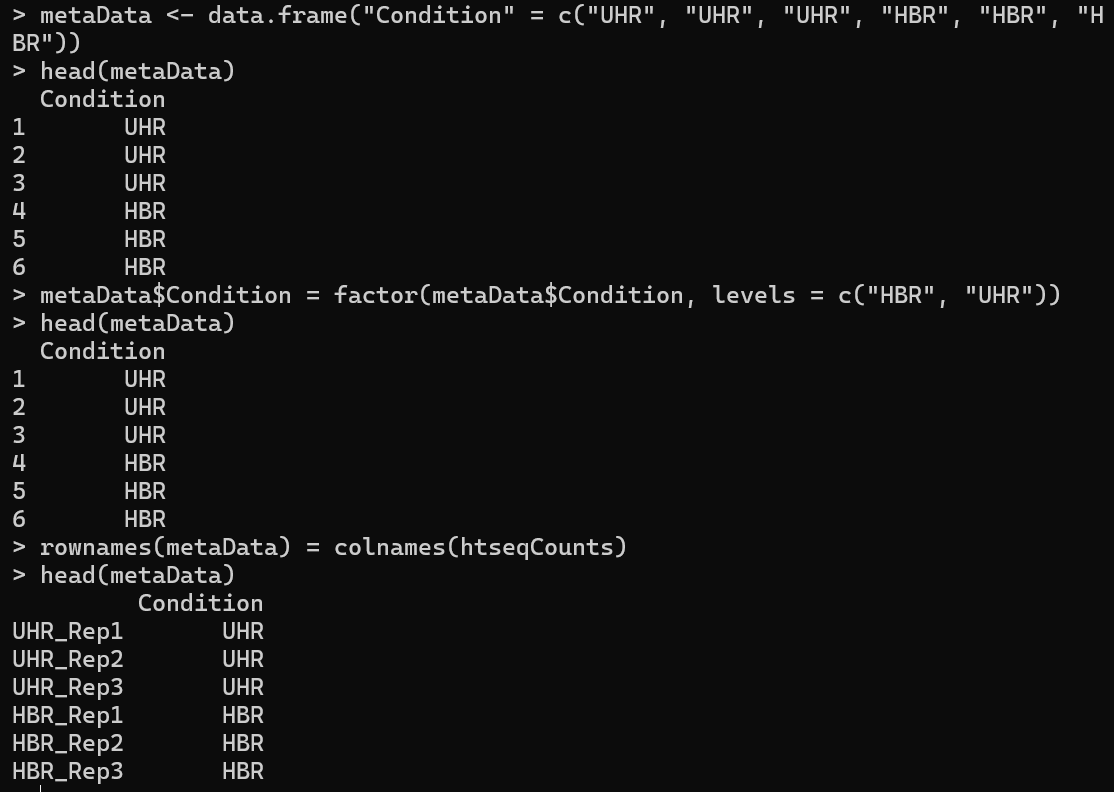

#### 4. Result of DESeq2

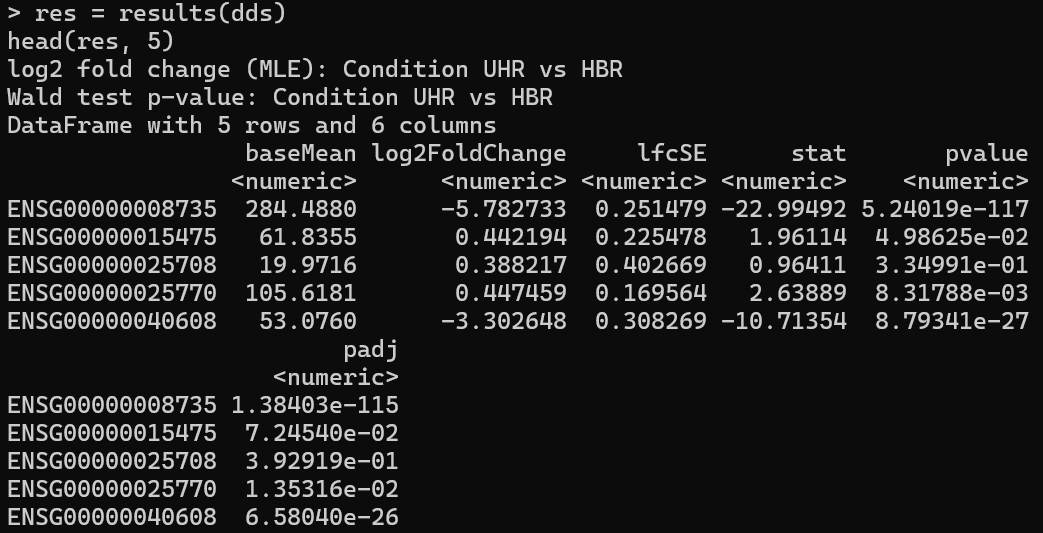

#### 5. the name of the coefficient (log fold change) to shrink

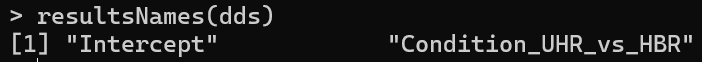

#### 6. Before and after log2FC shrinkage

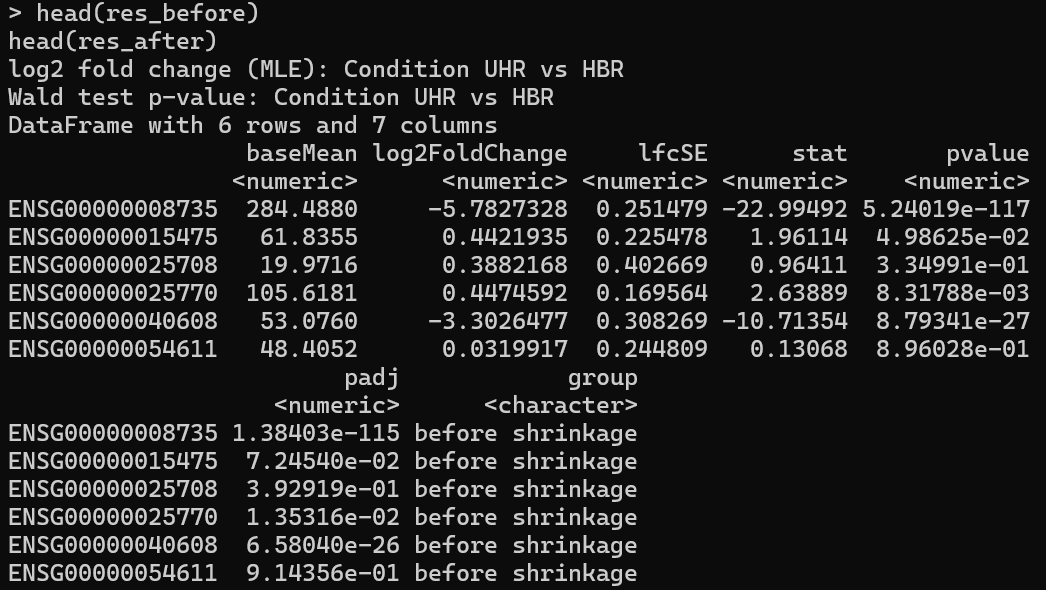
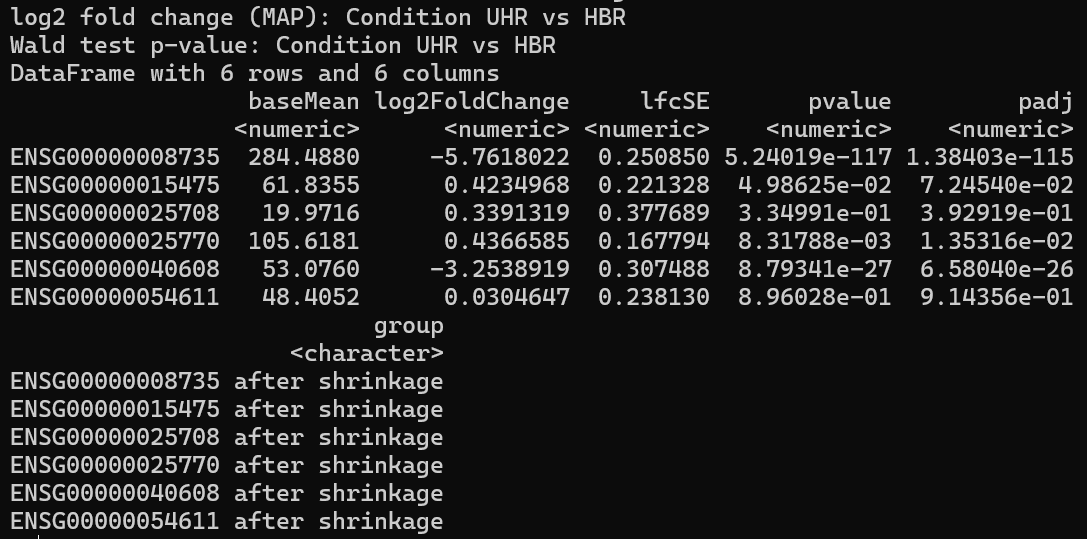

- Question: How did the results change before and after shinkage? What direction is each log2 fold change value moving?
- Answer: Note that for these data, the impact of shrinkage is very subtle but the pattern is that fold change values move towards 0.

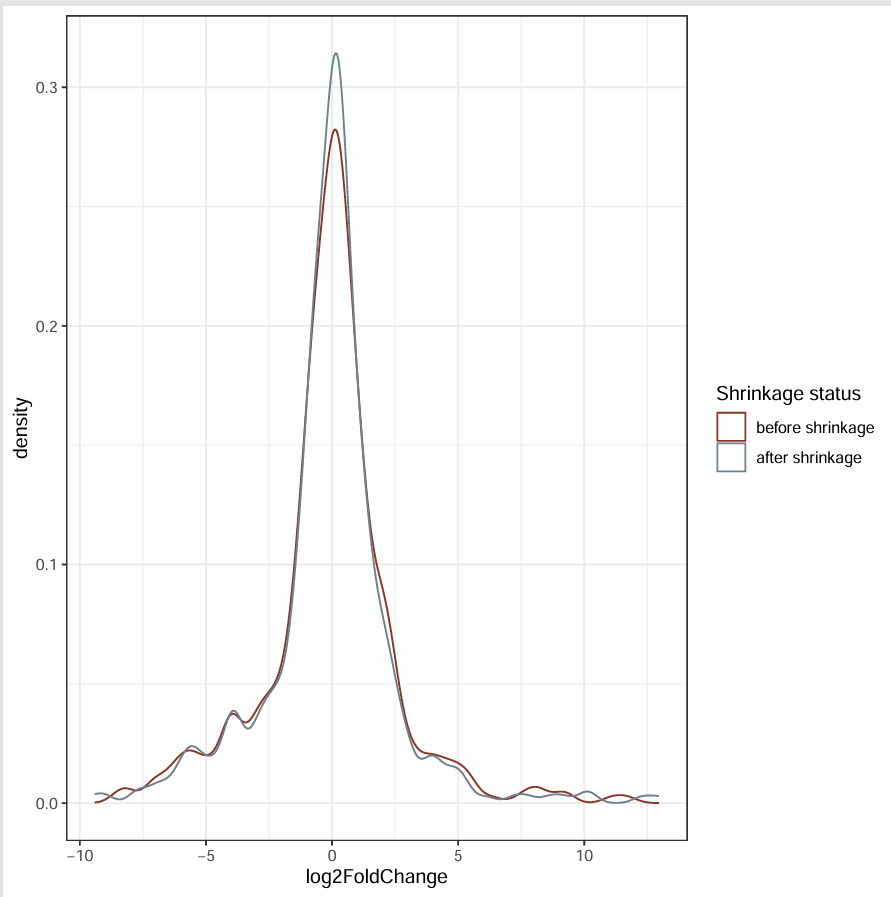

View your plot at: http://your-public-IPv4/rnaseq/de/deseq2/DESeq2_log2FC__shrinkage.pdf

**🔴 Red Line — "before shrinkage":**
- These are the original log2 fold changes estimated by DESeq2 without shrinkage.
- You'll notice it has slightly heavier tails on both sides — more extreme log2FC values, both positive and negative.

**🔵 Blue Line — "after shrinkage":**
- These are the log2FC values after applying lfcShrink() with apeglm.
- The curve is more peaked at 0, with less density in the tails on both sides.
- This indicates that extreme log2FC values have been pulled closer to zero, which is exactly what shrinkage does.

#### 7. deGeneResult before and after
**before adding a column called "ensemblID"**

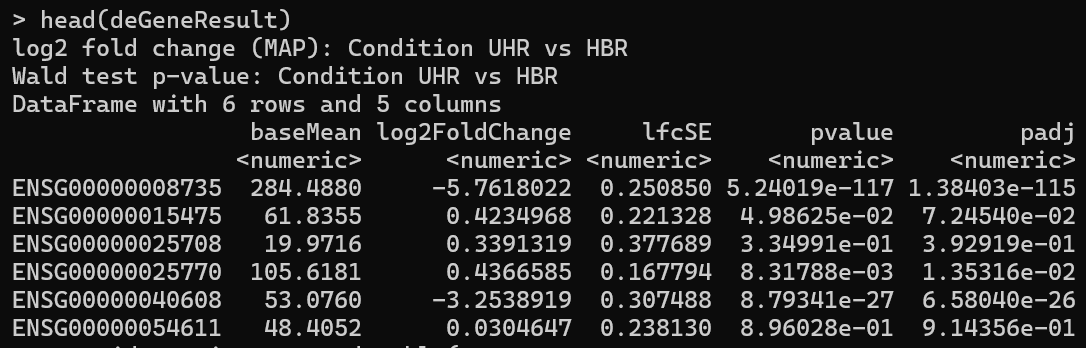

**after adding a column called "ensemblID"**

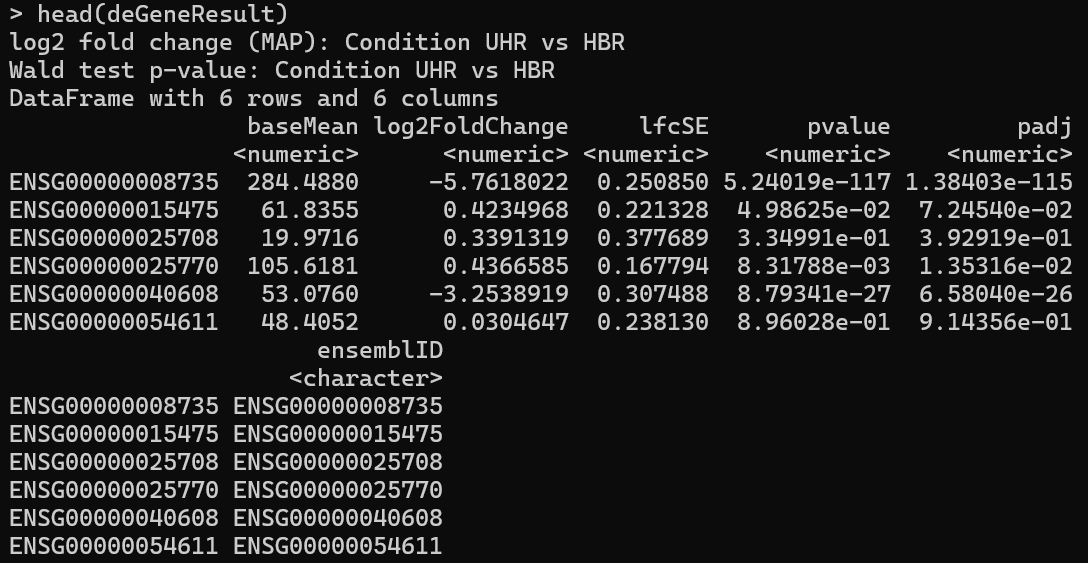

**after merging gene names (symbols) according to ensemblID**

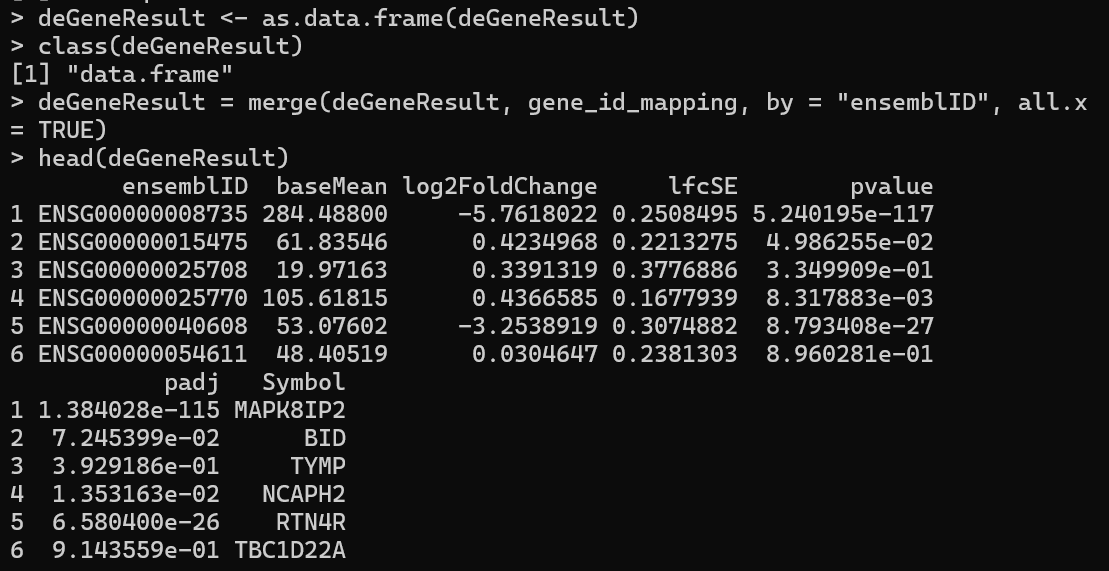

**after merging HTseq counts**

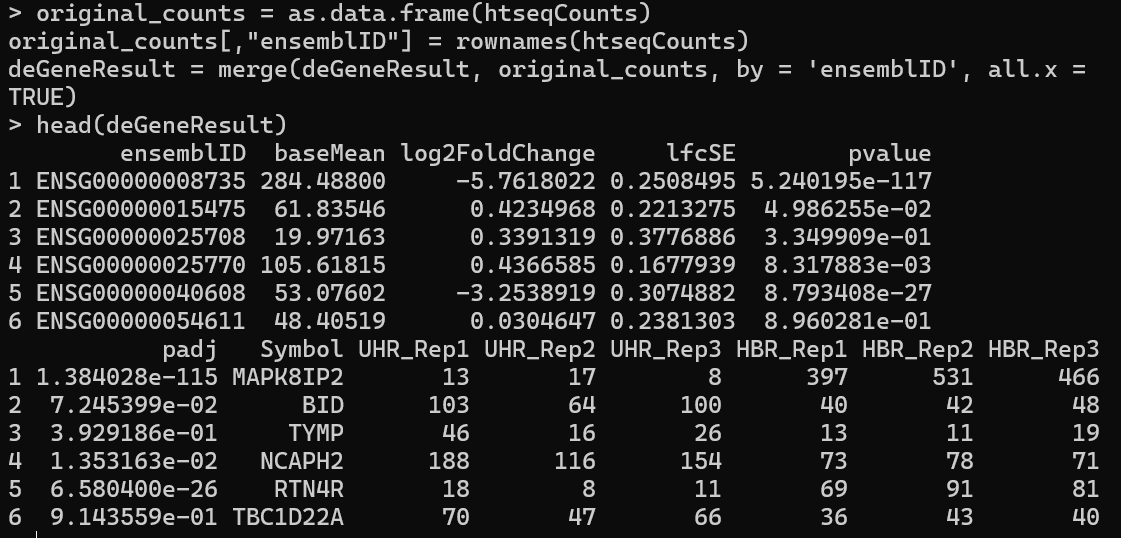

#### 8. top genes according to adjusted p-value

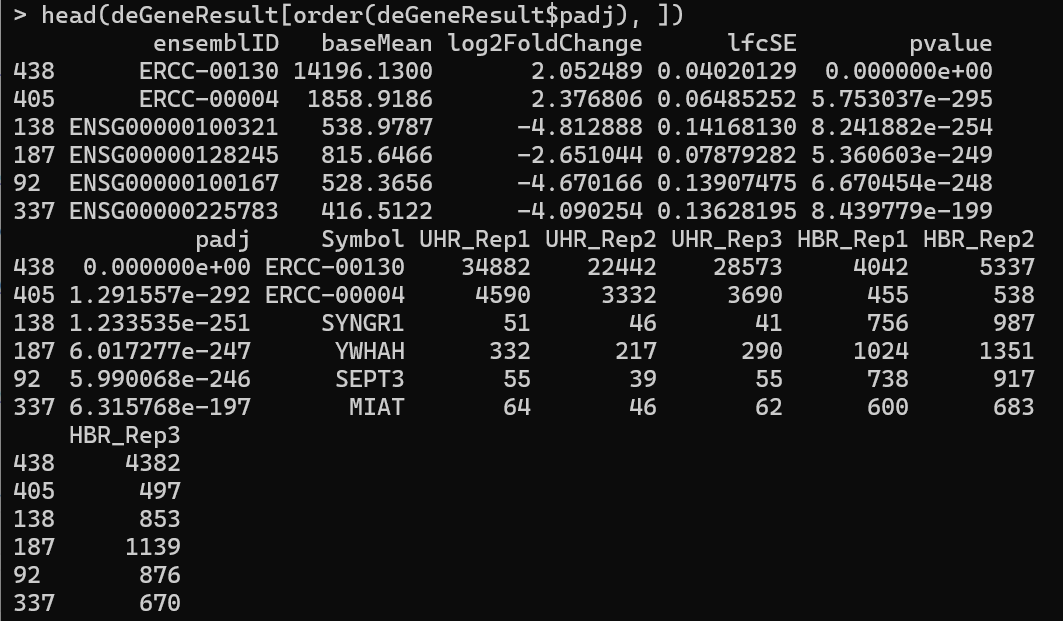

#### 9. Top 10 over-expressed genes with p-adj < 0.05 and large log2FC for 

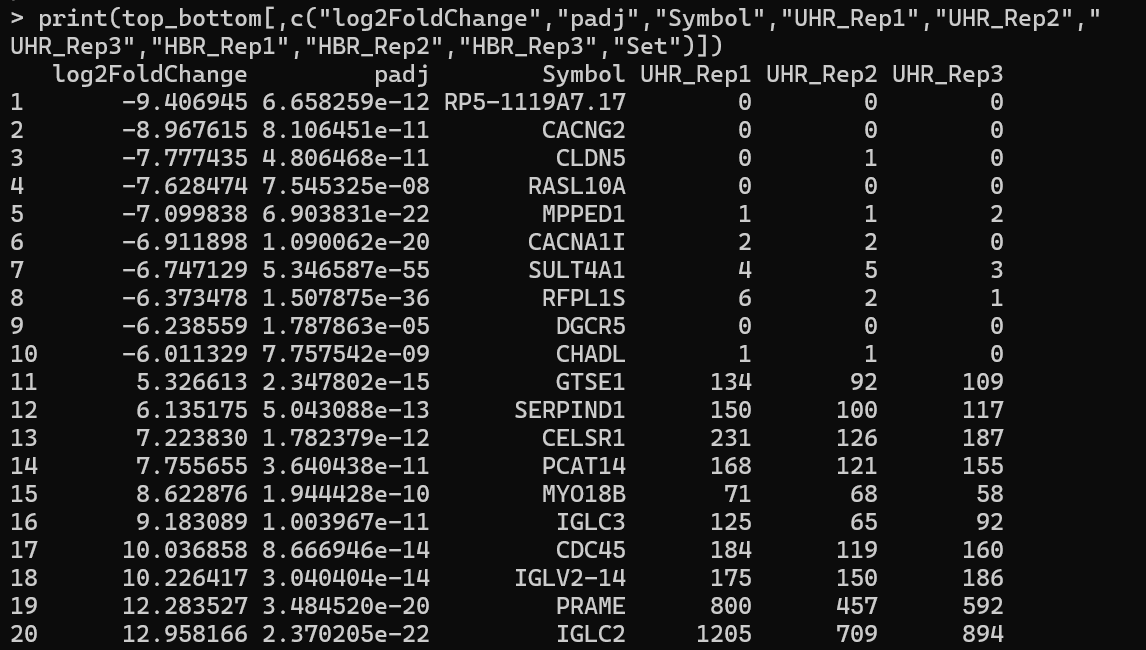
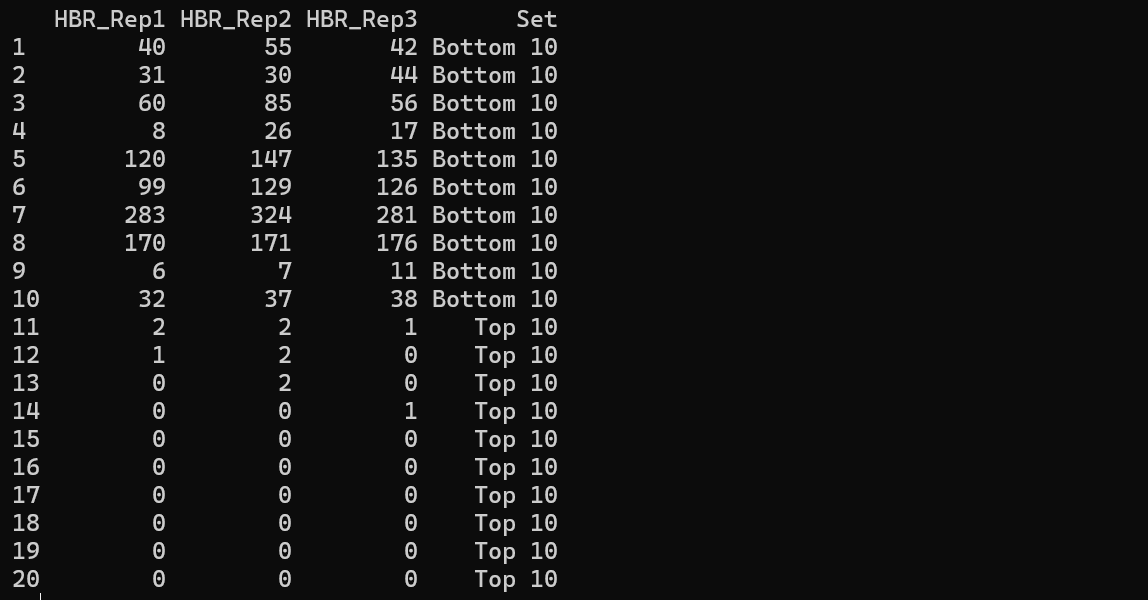

## Preliminary exploration of DE genes using webtools
- Download the file: outdir/DE_sig_genes_DESeq2.tsv. Open this on Excel as "Delimited", check the box "My data has header", select and "Tab", set "ensemblID" and "Symbol" columns as "Text", the rest as "General", sort on “log2FoldChange” column (smallest to largest) and find the top 100 significant genes with higher expression in HBR (brain). These log2FoldChange are large negative numbers. 
- Also download the file: outdir/DE_all_genes_DESeq2.tsv (to be used as a list of background genes or where we want the fold-change value for every gene).

- Try querying with the top 100 HBR over-expressed genes (either ensemblID or Symbol works) using: [g:Profiler](https://biit.cs.ut.ee/gprofiler/gost)
- Try querying with the top 100 HBR over-expressed genes using: [TissueEnrich](https://tissueenrich.gdcb.iastate.edu/). Use the Tissue Enrichment tool. This tool also requires a Background Gene List. Copy/Paste all 449 gene symbols in DE_all_genes_DESeq2.tsv as Background Gene List. You can also manually explore some individual genes over-expressed in UHR with the Tissue-Specific Genes tool. For example, try PRAME and SERPIND1, two of the top UHR genes.

Remember that UHR ([Universal Human Reference](https://rnabio.org/assets/module_1/UHR.pdf)) is total RNA isolated from a diverse set of 10 cancer cell lines (breast, liver, cervix, testis, brain, skin, fatty tissue, histocyte, macrophage, T cell, B cell). The HBR ([Human Brain Reference](https://rnabio.org/assets/module_1/HBR.pdf)) is total RNA isolated from the brains of 23 Caucasians, male and female, of varying age but mostly 60-80 years old.

When DESeq2 outputs something like: "log2 fold change: Condition UHR vs HBR"

…it means the log2 fold change (log2FC) was calculated as:

\begin{equation*}
\log_2\text{FoldChange} = \log_2 \left( \frac{\text{expression in UHR}}{\text{expression in HBR}} \right) = \log_2(\text{UHR}) - \log_2(\text{HBR})
\end{equation*}

🔍 Interpretation:
- A positive log2FC → gene is upregulated in UHR relative to HBR.
- A negative log2FC → gene is downregulated in UHR (i.e., upregulated in HBR).

### Full-name of GO terms:

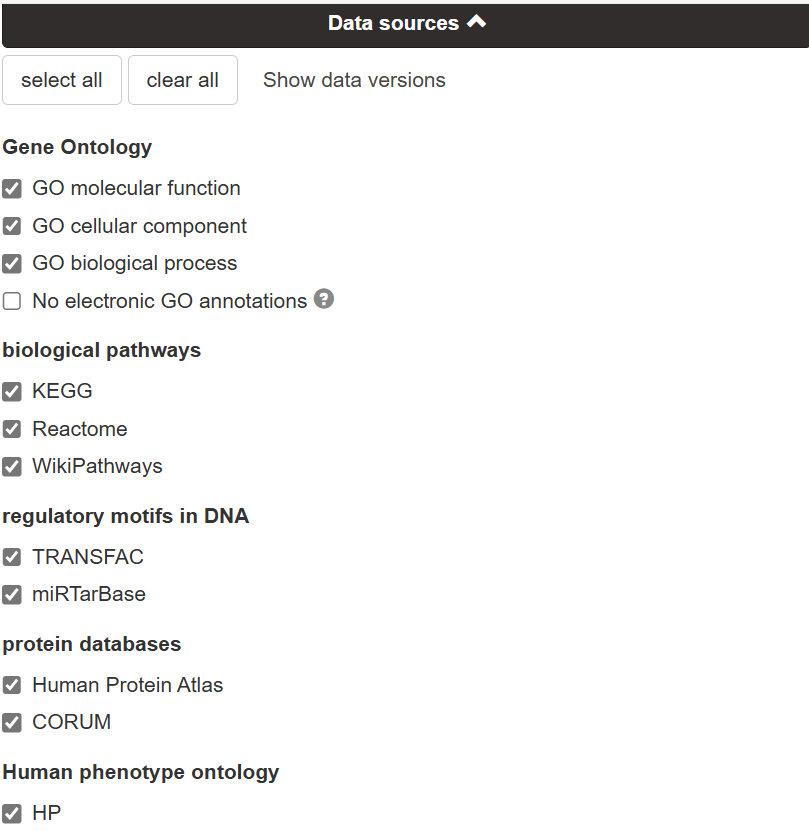

#### GO analysis of HBR over-expressed genes (large negative log2FC) - sort log2FC from smallest to largest -> take the top 100 genes
Note that after pasting either ensemblID or Symbol and "Run Query", only 2 rows showed up. I need to manually look for data points whose Term IDs shown in the course's image result. 

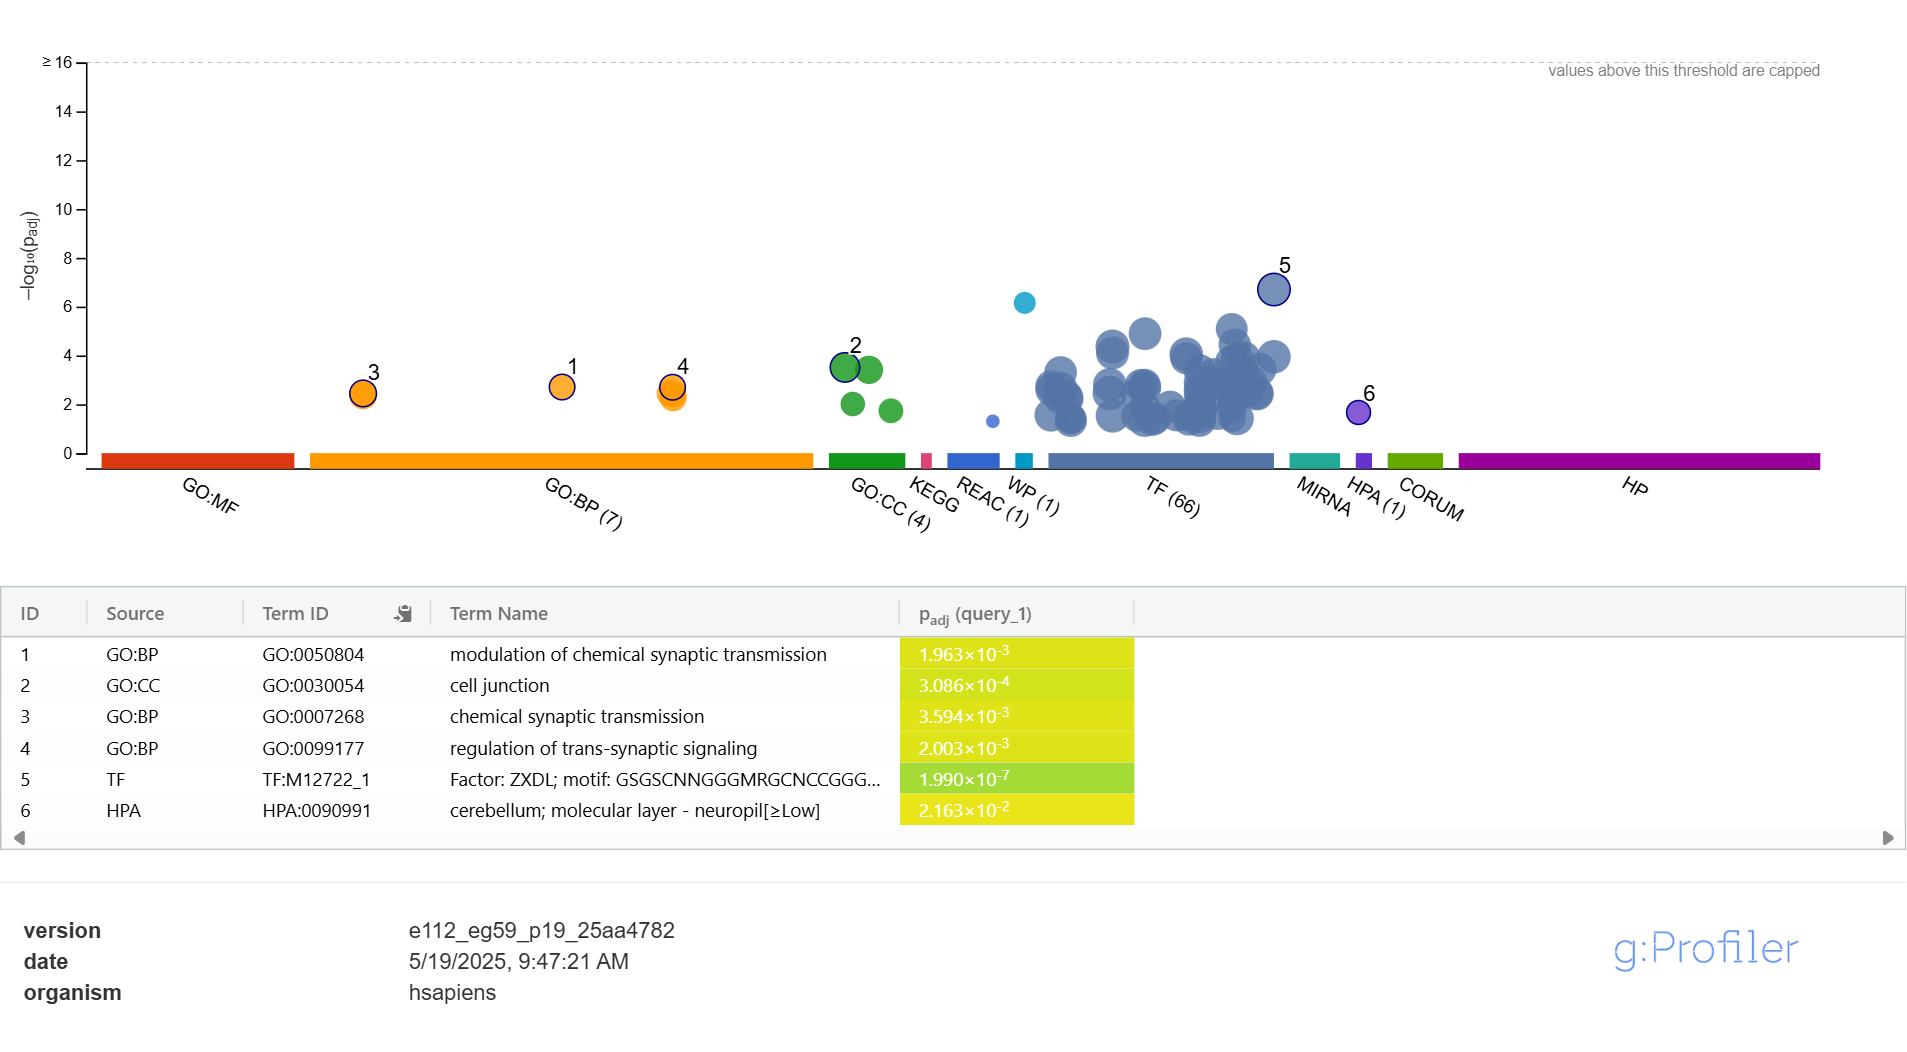

#### GO analysis of UHR over-expressed genes (large positive log2FC) - sort log2FC from largest to smallest -> take the top 100 genes

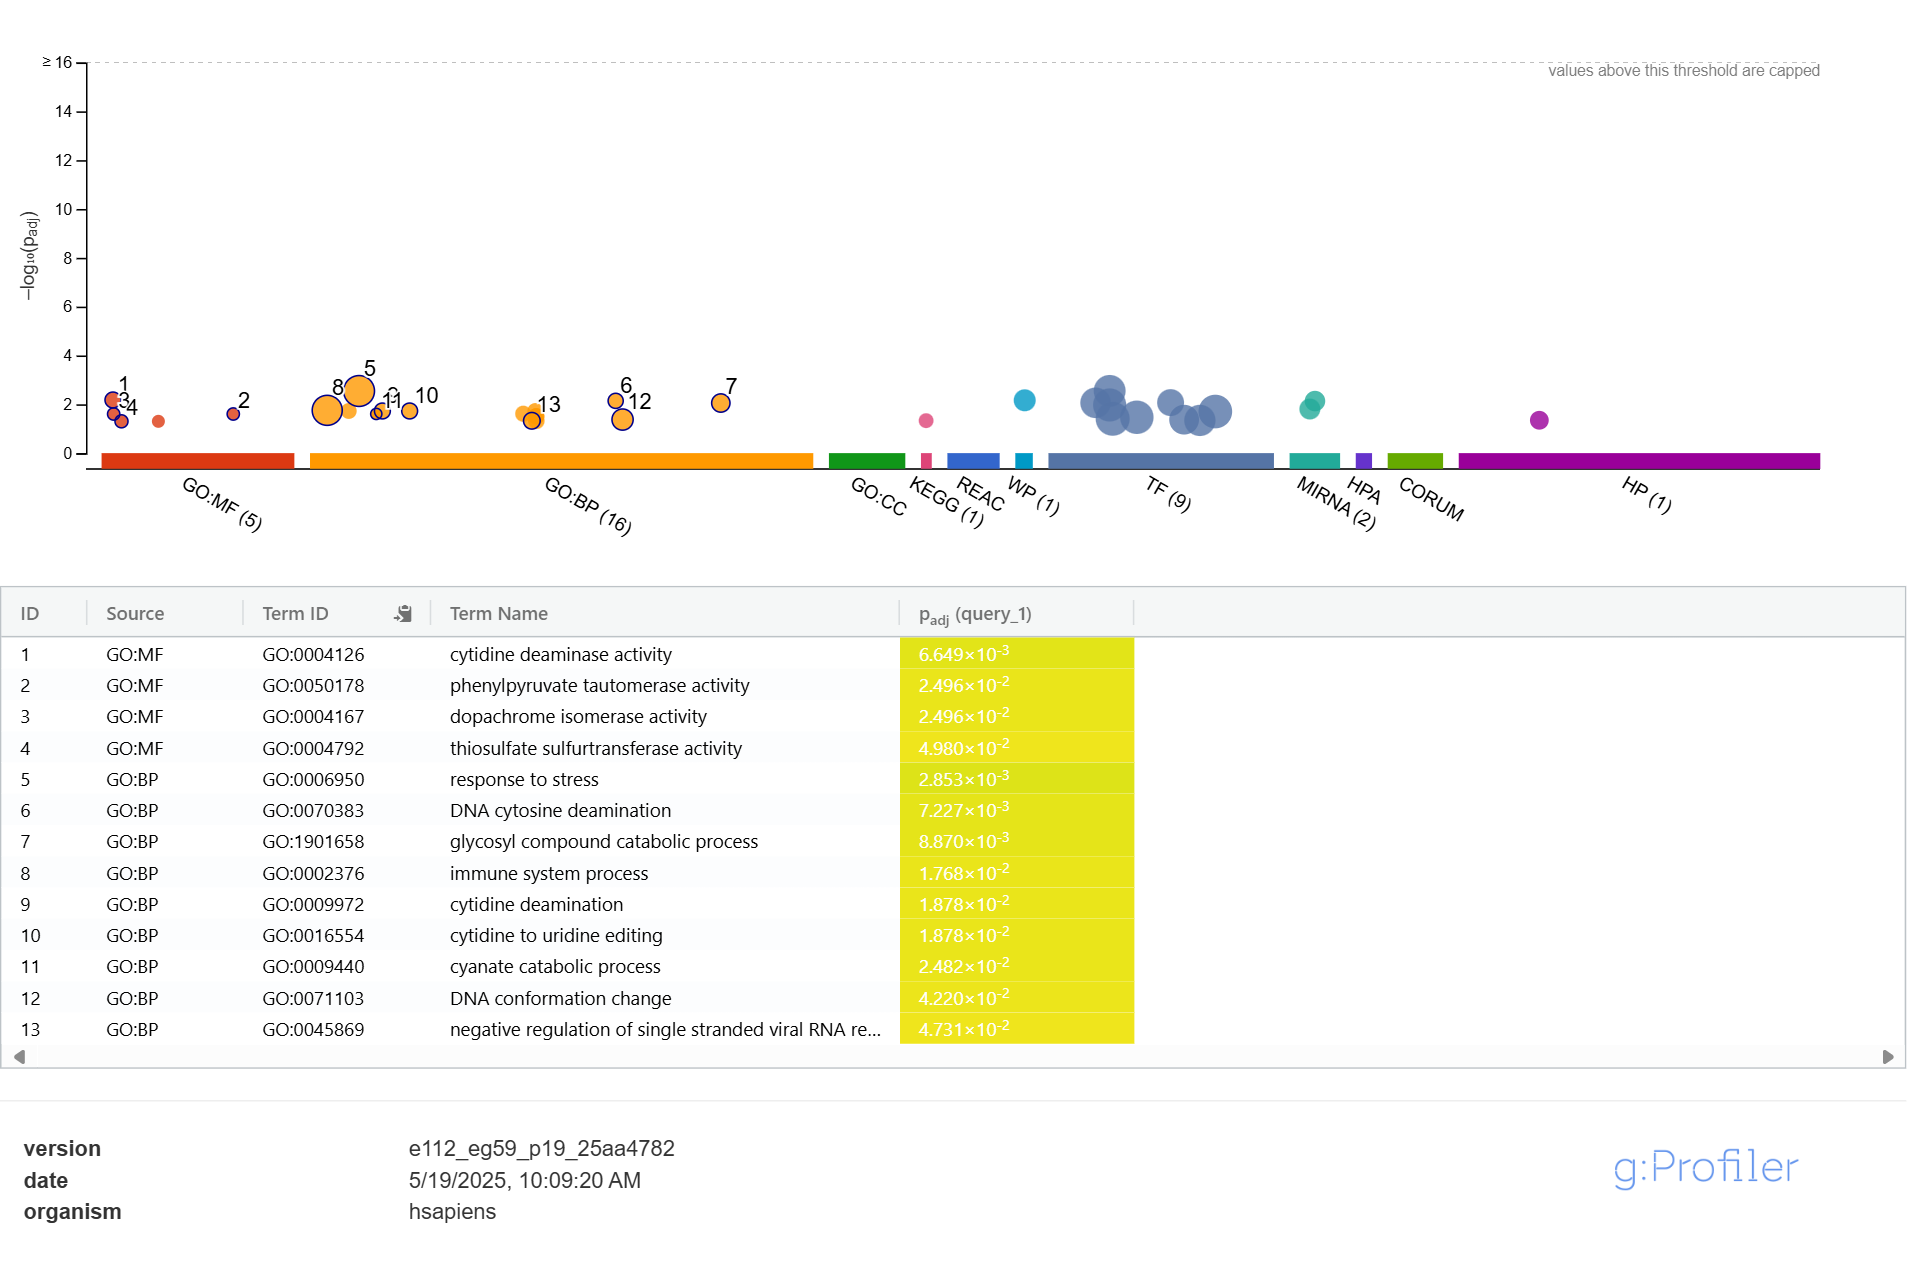

#### TissueEnrich Analysis for top 100 HBR over-expressed genes (large negative log2FC)

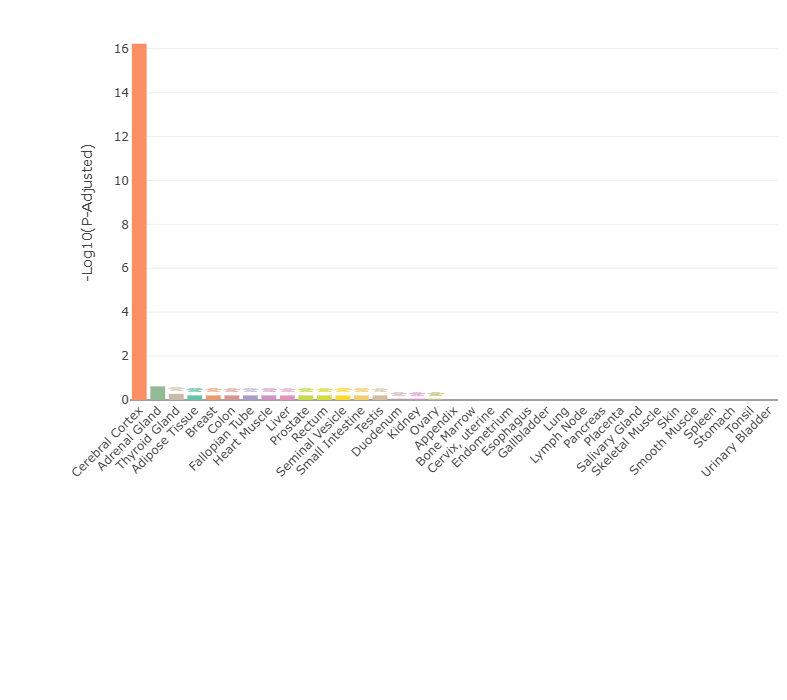

#### TissueEnrich Analysis for top 100 UHR over-expressed genes (large positive log2FC)

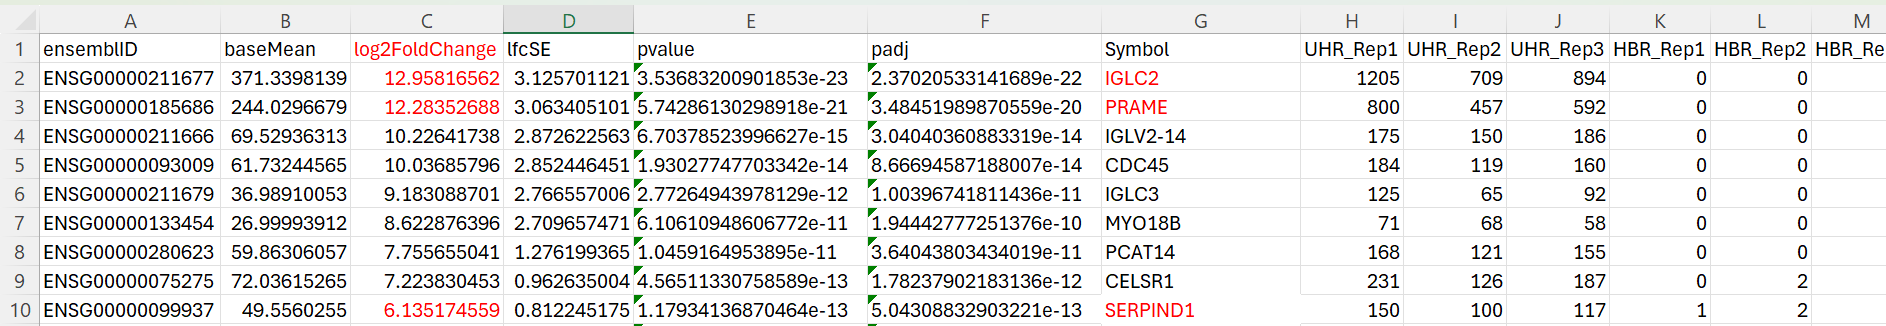

##### For some reason, IGLC2 and PRAME doesn't produce plots

##### TissueEnrich analysis for SERPIND1

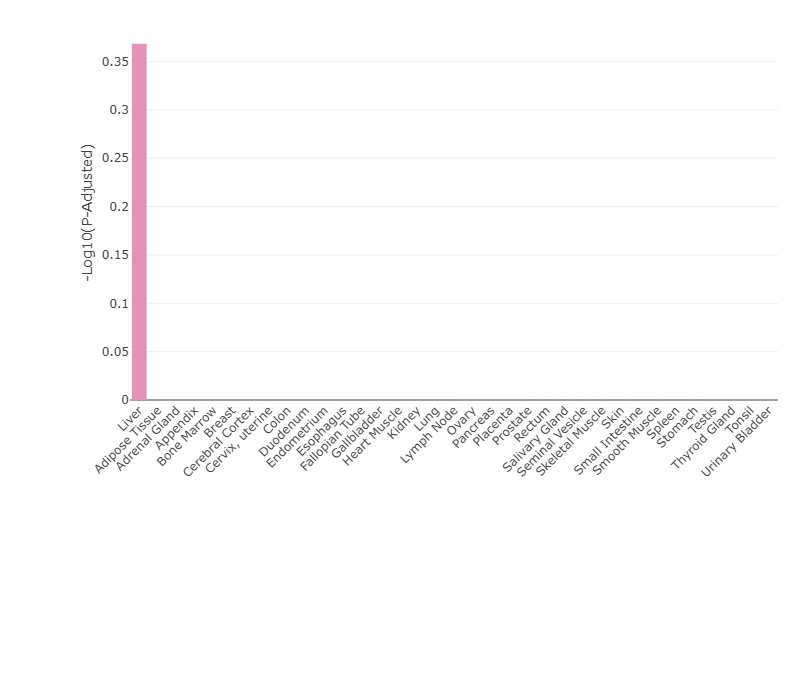